## **Spotify - prediction of songs popularity**

Alessandro Parroco, s202884

Albert Alcalde, s202956

Pau Blanco, s202611

Berta Viñas, s202256

In [ ]:
# First, we need to download an auxiliary Python file for STAN
!wget http://mlsm.man.dtu.dk/mbml/pystan_utils.py

--2021-05-26 17:29:23--  http://mlsm.man.dtu.dk/mbml/pystan_utils.py
Resolving mlsm.man.dtu.dk (mlsm.man.dtu.dk)... 192.38.87.226
Connecting to mlsm.man.dtu.dk (mlsm.man.dtu.dk)|192.38.87.226|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2661 (2.6K) [text/x-python]
Saving to: ‘pystan_utils.py’

pystan_utils.py     100%[===================>]   2.60K  --.-KB/s    in 0s      

2021-05-26 17:29:23 (230 MB/s) - ‘pystan_utils.py’ saved [2661/2661]



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from sklearn import linear_model
import pystan
import pystan_utils

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


## 1. Dataset and research question

### 1.1. The Datset: Spotify tracks

The dataset used for the final project is the Spotify songs dataset. The dataset contains more than 175.000 songs from Spotify released between 1920 and 2021, collected using the Spotify Web API. It provides information about the artist, year or popularity. The file analyzed is called "data.csv".

The dataset was taken from Kaggle: https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks




In [ ]:
path = "/content/drive/My Drive/DTU/Model-based Machine Learning/MBML Project/data.csv"
spot = pd.read_csv(path, index_col=["id", "name"])
spot_class=spot#keep original dataset for classification model preprocessing, later

In [ ]:
spot.columns

Index(['acousticness', 'artists', 'danceability', 'duration_ms', 'energy',
       'explicit', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'popularity', 'release_date', 'speechiness', 'tempo', 'valence',
       'year'],
      dtype='object')

Description of the variables:

- **Acousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic.

- **Artists**: Artist of the song.

- **Danceability**: Describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity.

- **Duration**: The duration of the track in milliseconds.

- **Energy**: Represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale.

- **Explicit**: The song includes explicit content.

- **Instrumentalness**: Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”.

- **Key**: The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on.

- **Liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live.

- **Loudness**: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks.

- **Mode**: Indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

- **Popularity**: Popularity of the song, values from 0 to 100, being the last one the most popular.

- **Release date**: Date when the song was released.

- **Speechiness**: This detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value.

- **Tempo**: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece, and derives directly from the average beat duration.

- **Valence**: Describes the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

- **Year**: Describes the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

source: https://towardsdatascience.com/what-makes-a-song-likeable-dbfdb7abe404#:~:text=Valence%3A%20Describes%20the%20musical%20positiveness,sad%2C%20depressed%2C%20angry).

### 1.2. Scope and research question

The Scope of this project is to determine the features that a song has to have in order to be apreciated by Spotify users, through the usage of a probabilistic model. That means predicting wheater an upcoming song will have high ratings or not in terms of "popularity".

## 2. Data preparation and descriptive stats

### 2.1. Data cleaning

First, some features of the dataset will be removed, since they are considered out of the scope of the research question or not useful.

In [ ]:
features_to_exclude = {"mode", "key", "liveness", "artists", "explicit", "loudness", "release_date"}
tot_features = set(spot.columns)
features = tot_features - features_to_exclude

spot = spot[features]
groups = spot.groupby("year")
groups.head()

danceability  ...    tempo
id                     name                                                              ...         
0cS0A1fUEUd1EW3FcF8AEI Keep A Song In Your Soul                                   0.598  ...  149.976
0hbkKFIJm7Z05H8Zl9w30f I Put A Spell On You                                       0.852  ...   86.889
11m7laMUgmOKqI3oYzuhne Golfing Papa                                               0.647  ...   97.600
19Lc5SfJJ5O1oaxY0fpwfh True House Music - Xavier Santos & Carlos Gomix...         0.730  ...  127.997
2hJjbsLCytGsnAHfdsLejp Xuniverxe                                                  0.704  ...  122.076
...                                                                                 ...  ...      ...
4i5y4THQZ7Kx2N74UISd95 Because You're Young (2007)                                0.219  ...  192.086
35N5RExHrhOoQZJtZpfrkM Desolation Row - Live From Osaka/2008                      0.161  ...  180.389
5hLTnrrsYuW0S3Zzm4iNbQ 2010 Was a Bad Year (Albert's Song)                        0.479  ...  109.560
1R9zW8DFjW6NLDjrlKwCyN The Loveliest Night Of The Year - 2017 Version             0.181  ...   83.181
3EH0f8p6ixeN0agJCSZz9R Still Crazy After All These Years - Live at Hyd...         0.230  ...   79.686

[510 rows x 10 columns]

In [ ]:
spot.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 174389 entries, ('0cS0A1fUEUd1EW3FcF8AEI', 'Keep A Song In Your Soul') to ('57tgYkWQTNHVFEt6xDKKZj', 'Improvisations')
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   danceability      174389 non-null  float64
 1   popularity        174389 non-null  int64  
 2   acousticness      174389 non-null  float64
 3   speechiness       174389 non-null  float64
 4   year              174389 non-null  int64  
 5   valence           174389 non-null  float64
 6   instrumentalness  174389 non-null  float64
 7   energy            174389 non-null  float64
 8   duration_ms       174389 non-null  int64  
 9   tempo             174389 non-null  float64
dtypes: float64(7), int64(3)
memory usage: 27.0+ MB


The dataset taken into account is well structured, it hasn't missing values and it is totally made of numeric values (apart from the Index column, which is composed by the name of the track and the spotify ID).

The following output will show basic statistics behind each feature of the dataset:

In [ ]:
spot.describe().round(4)

danceability   popularity  ...   duration_ms        tempo
count   174389.0000  174389.0000  ...  1.743890e+05  174389.0000
mean         0.5368      25.6934  ...  2.328100e+05     117.0065
std          0.1760      21.8727  ...  1.483958e+05      30.2542
min          0.0000       0.0000  ...  4.937000e+03       0.0000
25%          0.4140       1.0000  ...  1.661330e+05      93.9310
50%          0.5480      25.0000  ...  2.057870e+05     115.8160
75%          0.6690      42.0000  ...  2.657200e+05     135.0110
max          0.9880     100.0000  ...  5.338302e+06     243.5070

[8 rows x 10 columns]

It can be noticed that "instrumentalness", "speachiness", "energy", "danceability" and "valence" are values between 0 and 1, as already mentioned in the description of the dataset.

The "year" column contains values between 1920 and 2021: this means that the tracks belonging to the dataset have been released in 101 years.

### 2.2. Model features and target variable

The model features (variables) will be the ones mentioned above, while the target variable will be the popularity.

In [ ]:
y = ["popularity"]
x = features - {"popularity"} -{"year"} - {"tempo"}

### 2.3. Features distributions

In order to explore the distributions of each of the features that will be used, in the next cells the histograms are shown.

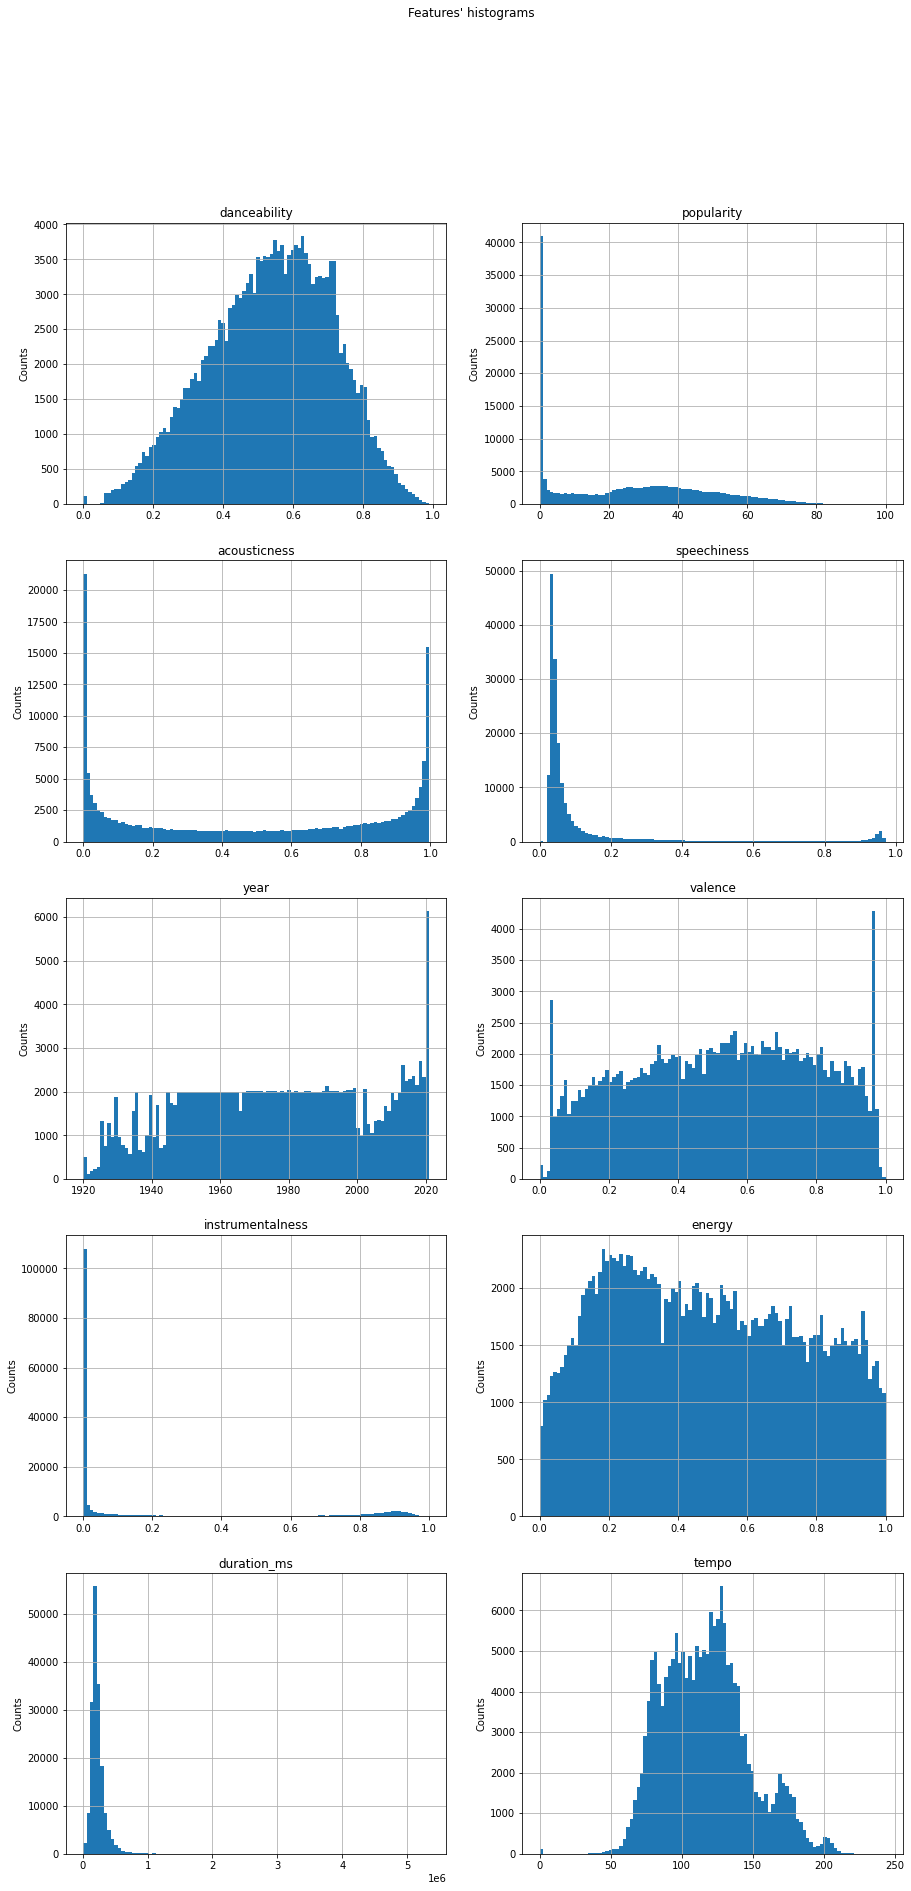

In [ ]:
fig, axs = plt.subplots(5, 2, figsize=(15,30))
fig.suptitle("Features' histograms")

k = 0
for i in range(5):
    for j in range(2):
        spot[list(features)[k]].hist(ax=axs[i, j], bins = 100)
        axs[i, j].set_ylabel("Counts")
        axs[i, j].set_title(list(features)[k])
        k += 1       
        
sns.set()

### 2.4. Covariance matrix and others correlations between pairs of features

It is useful to analyze how the variables are statistically correlated, in order to properly understand the relationships between pairs of variables. For this scope, two different tools will be involved:

1. The covariance matrix, which is a powerful tool in order to show linear relationships between the variables;

2. Scatterplots of the datapoints, for each pair of features, grouped by the release year. This tool is quite powerful, since it can show non-linear correlations, not detected by the covariance matrix.

The covariance matrix's plot is:

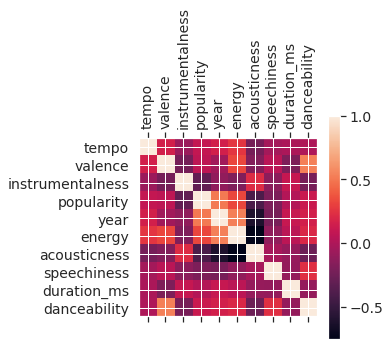

In [ ]:
plt.matshow(spot.corr())
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.xticks(range(spot.select_dtypes(['number']).shape[1]), spot.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(spot.select_dtypes(['number']).shape[1]), spot.select_dtypes(['number']).columns, fontsize=14)
plt.show()

The plot shows that the relationship between the pairs of the interest variables are mostly directly proportional, that is the values of pearsons' coefficient is positive, with few exceptions.

Three significant correlations can be observed in the matrix, corresponding to the light squares:
1. Year-Energy
2. Year-popularity
3. Valence-Danceability

In [ ]:
print("The correlation between year and energy is: ", round(spot["year"].corr(spot["energy"]), 3))
print("The correlation between year and popularity is: ", round(spot["year"].corr(spot["popularity"]), 3))
print("The correlation between Valence and danceability is: ", round(spot["valence"].corr(spot["danceability"]), 3))

The correlation between year and energy is:  0.541
The correlation between year and popularity is:  0.513
The correlation between Valence and danceability is:  0.537


The covariance matrix does not detect non-linear correlations between pairs of vaiables. Therefore, in order to show other kinds of dependencies, scatterplots of the variables will be drawn, divided by the  year:

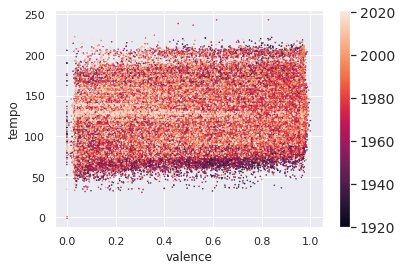

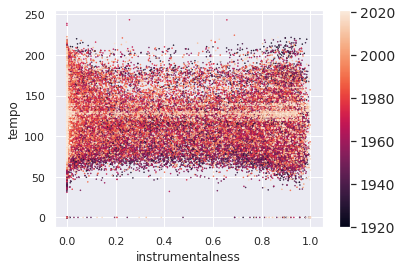

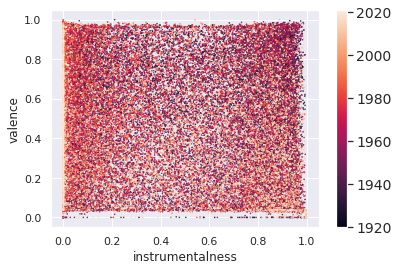

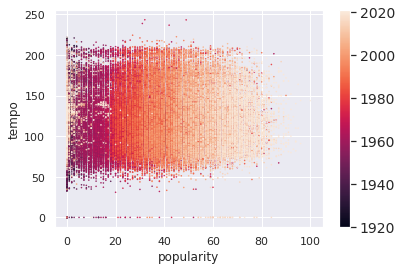

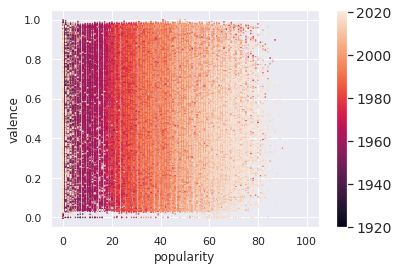

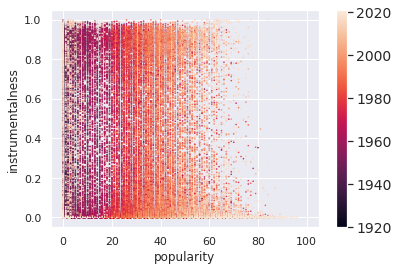

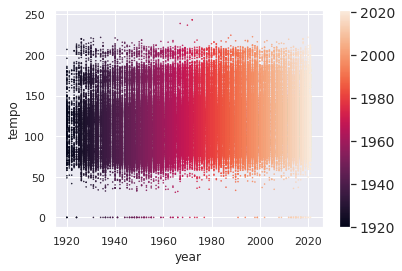

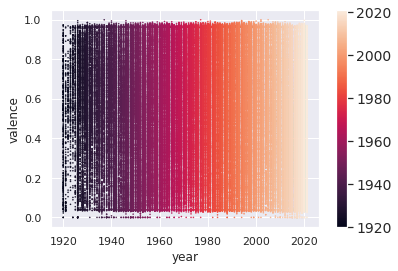

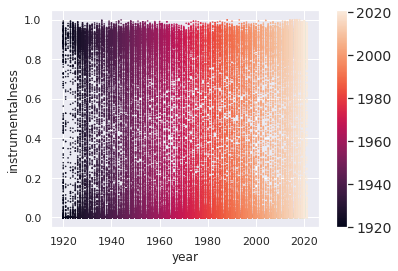

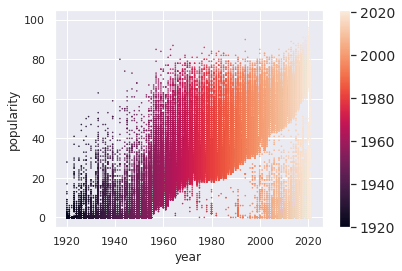

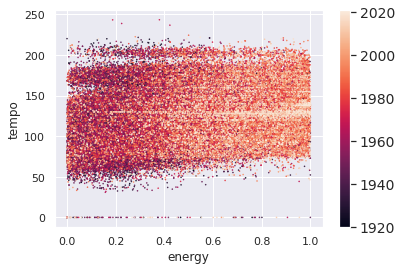

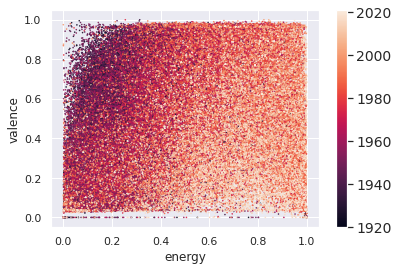

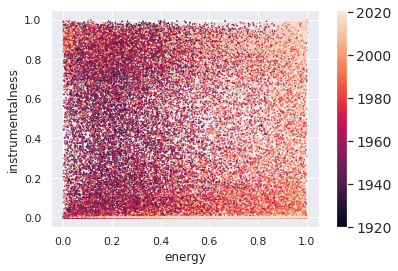

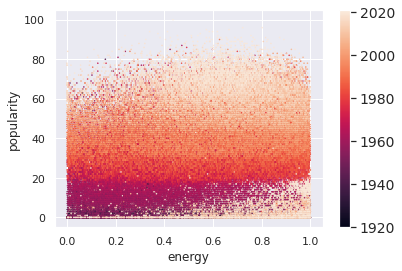

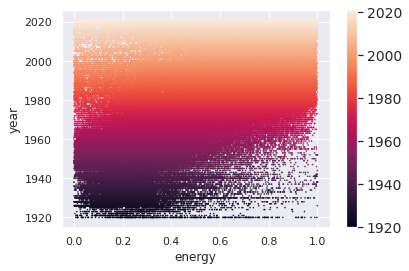

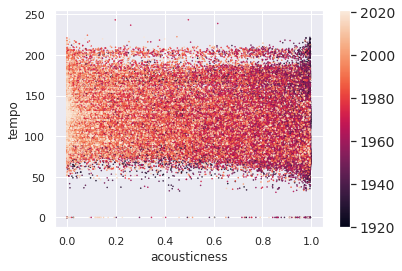

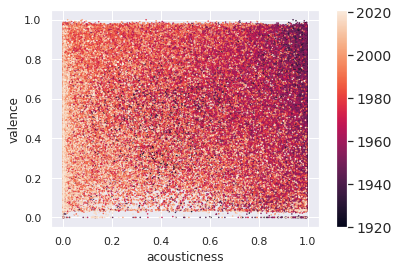

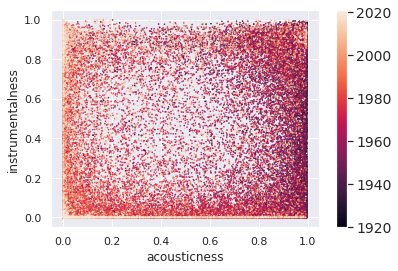

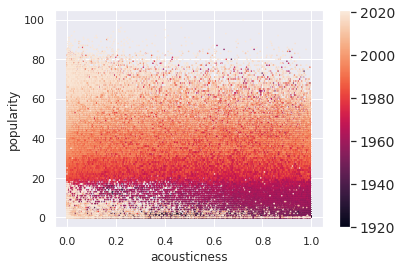

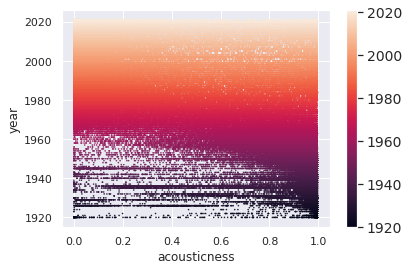

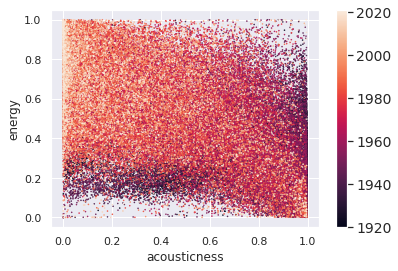

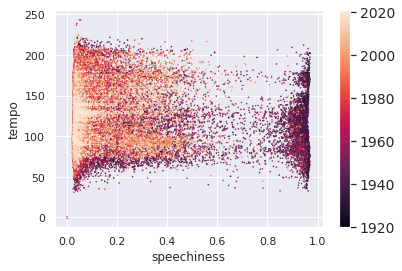

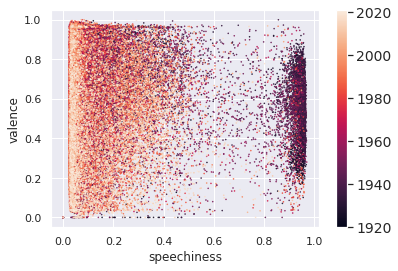

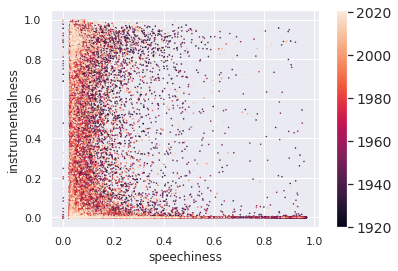

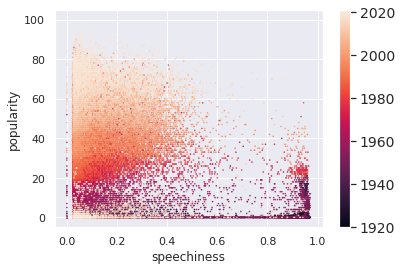

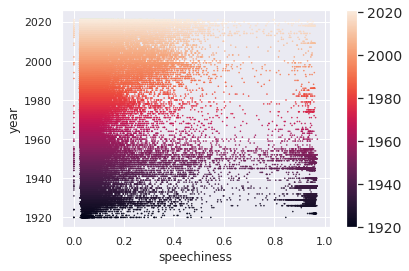

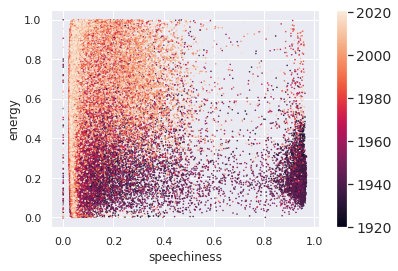

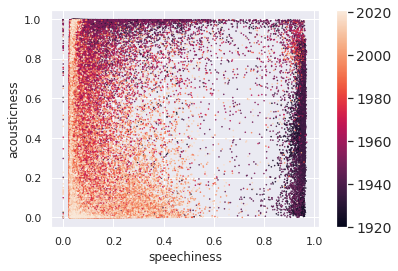

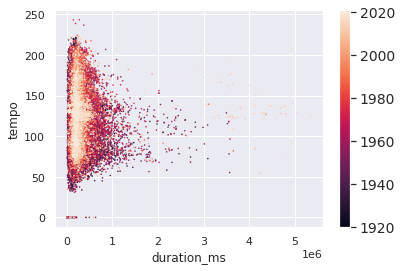

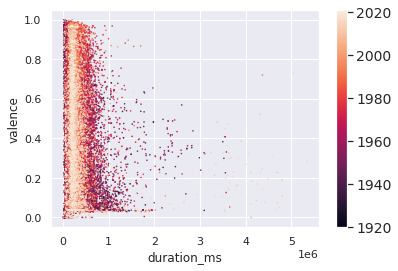

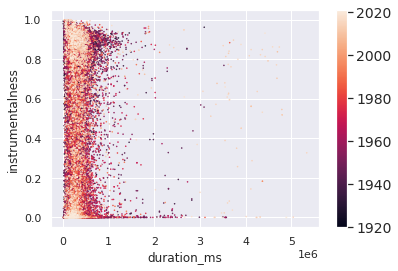

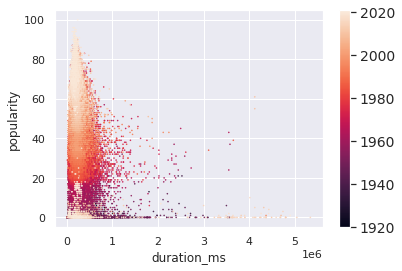

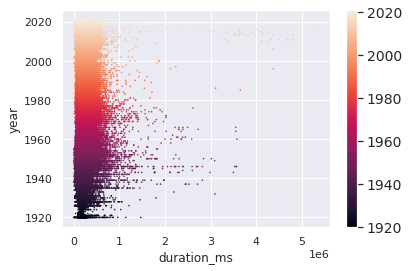

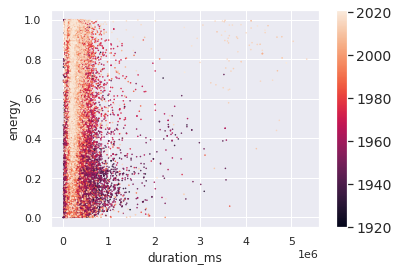

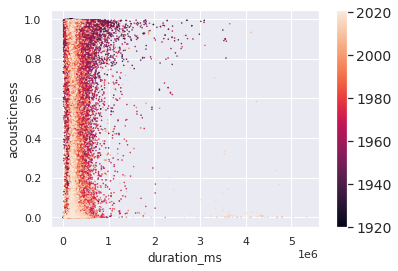

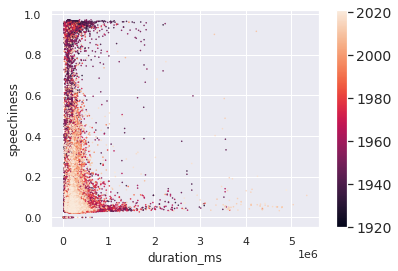

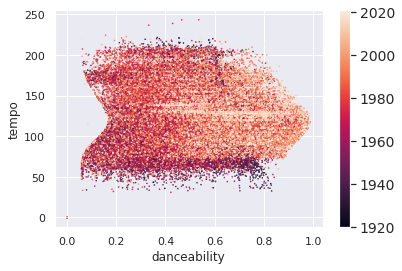

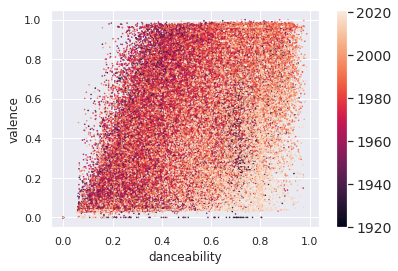

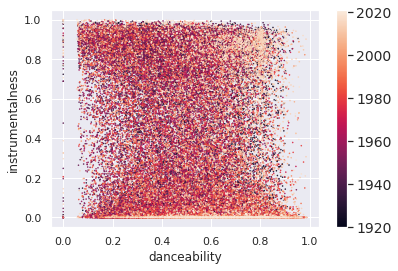

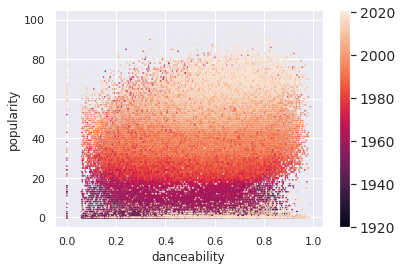

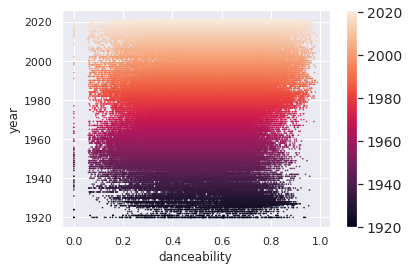

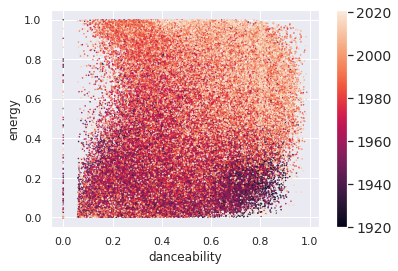

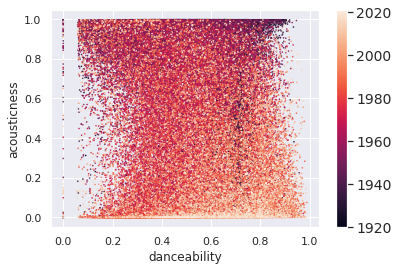

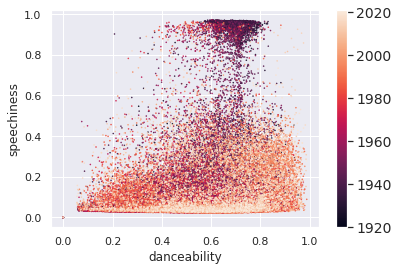

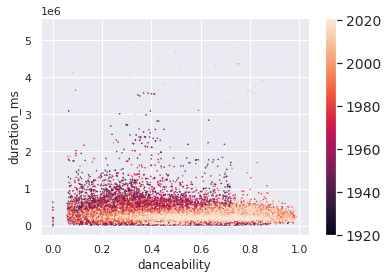

In [ ]:
for i in range(len(features)):
    for j in range(len(features)):
        if i > j:
            plt.xlabel(list(features)[i])
            plt.ylabel(list(features)[j])
            plt.scatter(spot[list(features)[i]], spot[list(features)[j]], s=0.3, c=spot['year'])
            cb = plt.colorbar()
            cb.ax.tick_params(labelsize=14)
            plt.show()

## 3. Models

### 3.1. Initial model

The goal is to model the popularity of a song as a function of the features: duration, acousticness, danceability, energy, instrumentalness, speechiness valence, year and tempo. It has been considered that accousticness, energy and danceability depend on the year the song was released and that the energy, danceability and valence depend on the tempo of the song. However, as these variables are observed, for the initial model the features year and tempo are not included.

#### 3.1.1. PGM

The probabilistic graphical model for the problem is the following:

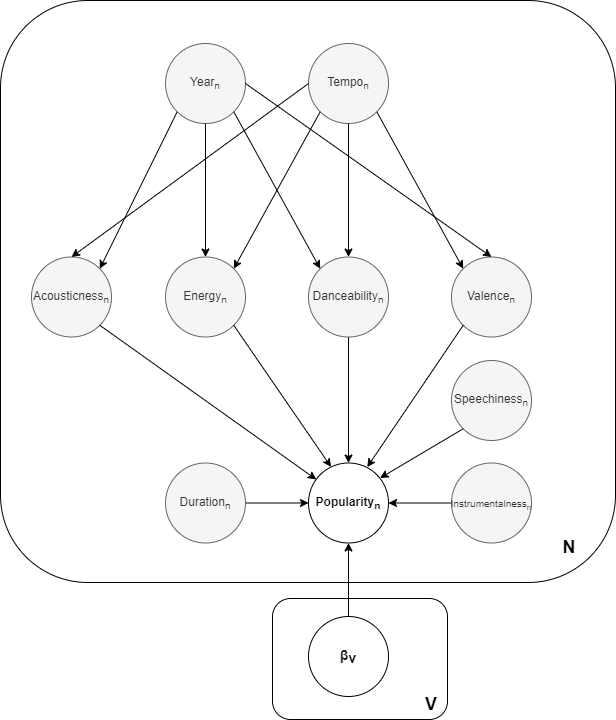

#### 3.1.2. Generative process

As a starting point, the model will consider all features of the song as observed variables.
The dataset consists of **N** observations of the target $Popularity_n$ which depends on the **V** corresponding explanatory variables which include: $Danceability_n$, $Valence_n$, $Energy_n$, $Acousticness_n$, $Speechiness_n$, $Instrumentalness_n$, $Duration_n$. All these features will be represented as $x_n$.

Notice that all the features have positive values.

There are also two variables which are assumed to be likelihoods of the previous explanatory variables: $Year_n$ and $Tempo_n$, which might be useful later on for more complex model approaches (for example if some of their childs, like $Acousticness_n$ or $Energy_n$ are set as unobserved variables becoming priors instead of likelihoods). 



The generative process for this initial model will be the following:

1) Draw intercept for popularity $ \alpha \sim \mathcal{N}(\alpha | 0, \gamma) $

2) Draw deviation for popularity $ \sigma \sim Cauchy(\sigma | 0, \xi) $

3) For v = 1,...,V: 

>  a) Draw coefficients for the predictors of popularity $ \beta_v \sim \mathcal{N}(\beta_v | 0, \lambda_v) $

4) For n = 1,...,N:

> a) Draw target $Popularity_n \sim \mathcal{N}(Popularity_n | \alpha + \beta'x_n, \sigma^2) $


#### 3.1.3. Implementation of the model

In the next cell, the matrix with the features and the target vector are initialized.

In [ ]:
X = spot[x].values
y = spot[y].values
y = y.ravel()

Then, the data is standarized.

In [ ]:
# standardize input features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

# standardize popularity
y_mean = y.mean()
y_std = y.std()
y = (y - y_mean) / y_std

Finally, the  data is split into a train and a test dataset.

In [ ]:
train_perc = 0.66 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
y_train = y[ix_train]
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 115096
num test: 59293


Define the function to compute the error in the predictions in order to evaluate the different models.

In [ ]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

##### 3.1.3.1. Sklearn Linear Regression


The first model to be implemented is the simple linear regression, and it will be implemented thanks to the ML package Sklearn.

The model is firstly initialized, it is fit to the train test and eventually the predictions come out:

In [ ]:
from sklearn.linear_model import LinearRegression
lr_sk = LinearRegression()

In [ ]:
lr_sk.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

The variable y_hat represents the vector with the predicted values. Nevrtheless, the values are still standardized, therefore it is necessary to go back to the original scale of the dataset, in order to make the predictions effective

In [ ]:
y_hat = lr_sk.predict(X_test)

In [ ]:
# convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

The performances of the model are then computed: as it is possible to notice, the correlation coefficient is not particularly good, and the RMSE is quite high, also considering that the value of popularity goes from 0 to 100.

In [ ]:
corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.515
MAE: 15.064
RMSE: 18.731
R2: 0.265


In order to visualize the performances of the models for all our different approaches two plots are displayed:
1. a line chart showing in blue the real value of the popularity, picked from the test set and in orange the prediction;
2. A scatterplot, displaying the distribution of the errors

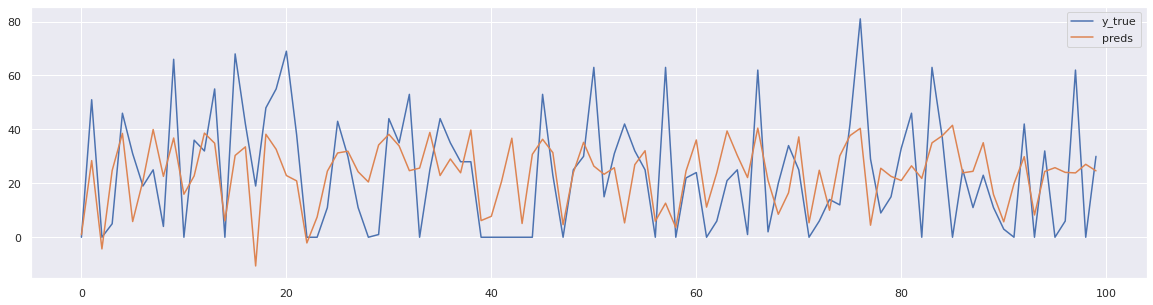

In [ ]:
fig = plt.figure(figsize=(20,5))
plt.plot(y_true[:100])
plt.plot(preds[:100])
plt.legend(["y_true", "preds"])
plt.show()

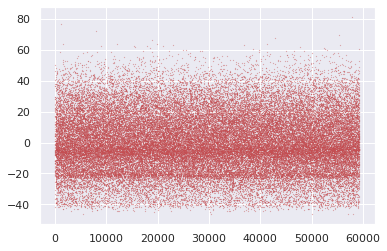

In [ ]:
err = y_true-preds
plt.scatter(np.arange(len(err)), err, s = 0.03, c="r")
plt.show()

The scatterplot shows that there are two clear lines where the points crowd: the first just below 0 and the second at around -20. Moreover, it can be noticed that the most of the points are above the 0, therefore the model tends to overstimate the popularity of the song.

##### 3.1.3.2. Ridge Regression

The second model to be implemented is the Ridge regression. Again, the dataset is prepared and standardized, then the model is fit.

In [ ]:
regr = linear_model.Ridge()
regr.fit(X_train, y_train)
y_hat = regr.predict(X_test)

# convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.515
MAE: 15.064
RMSE: 18.731
R2: 0.265


The performances are slightly worse than the sklearn lr, but the difference between the behaviors of the two models is not relevant.

The shape of the scatterplot reminds of the previous model.

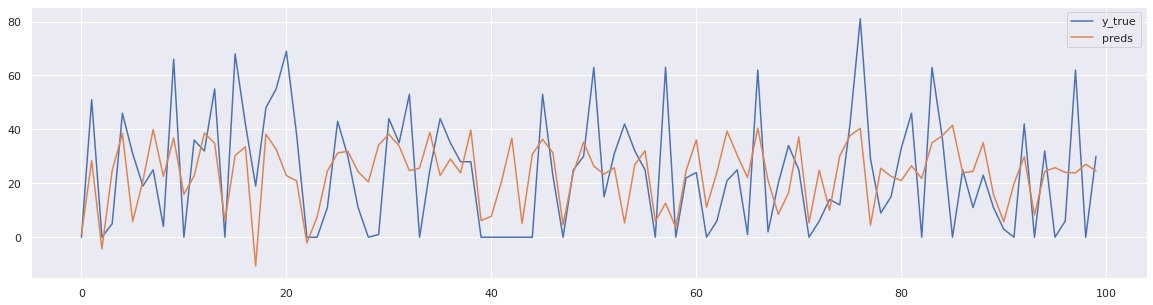

In [ ]:
fig = plt.figure(figsize=(20,5))
plt.plot(y_true[:100])
plt.plot(preds[:100])
plt.legend(["y_true", "preds"])
plt.show()

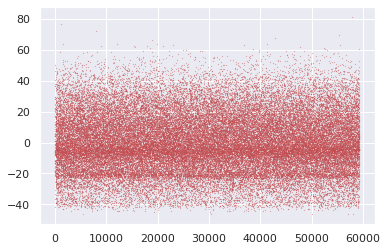

In [ ]:
err = y_true-preds
plt.scatter(np.arange(len(err)), err, s = 0.03, c="r")
plt.show()

As an addtional indicator, some percentiles of the errors are shown:

In [ ]:
count_10 = 0
count_20 = 0
count_5 = 0
for e in err:
#     print(e)
    if abs(e) < 5:
        count_20 += 1
    if abs(e)<10:
        count_10 += 1
    if abs(e) < 20:
        count_20 += 1

print("proportion of error less than 20: ", round(count_20/len(err), 2))
print("proportion of error less than 10: ", round(count_10/len(err), 2))
print("proportion of error less than 5: ", round(count_5/len(err), ))

proportion of error less than 20:  0.91
proportion of error less than 10:  0.41
proportion of error less than 5:  0


##### 3.1.3.3. Linear Regression

The inferential ML models are then applied to the dataset in order to predict the value of the popularity of a song. In order to do so, different algorithms are applied. The first algorithm to be applied is the "NUTS" algorithm.

The way it has been decided to procede is the following. First, a grid search on the linear regression has been implemented on a restricted sample of datapoints, in order to find the best standard deviation parameters for the distributions of alpha and beta. Then, the parameters chosen have been applied to the whole dataset in order to come out with the performances.

###### Grid search on linear regression

In [ ]:
i = str(5)

The stan model is then iterated on 4x4=16 different scenarios, to see the best value obtained.

The model implemented is the simple linear regression: there are two parameters, alpha and beta, representing respectively the intercept and the coefficients of the rect. They distribute as two normal distributions. On the other hand, sigma represents the prior on the variance and distributes like a cauchy.

Notice that in the grid search only two parameters will be tuned, for reasons of time.

The results for each implementation are shown in the output.


In [ ]:
# Grid Search on the standard deviations in the model
for ns in [5, 10, 12, 15, 17, 20]:
    for cs in [5, 10, 12, 15, 17, 20]:
        # define Stan model
        print("################## ##################################")
        model_definition ="""
        data {
            int<lower=0> N; // number of data items
            int<lower=0> D; // number of predictors
            matrix[N,D] x;  // predictor matrix
            vector[N] y;    // outcome vector
        }
        parameters {
            real alpha;             // intercept
            vector[D] beta;         // coefficients for predictors
            real<lower=0> sigma;    // error scale
        } 
        model {
            alpha ~ normal(0, %s);                        // prior on the intercept # 15 is better than 10
            sigma ~ cauchy(0, %s);                        // prior on the variance
            for (d in 1:D)
                beta[d] ~ normal(0,1);             // prior on the coefficients
            y ~ normal(alpha + x * beta, sigma);   // likelihood
        }
        """
        model_definition = model_definition %(ns, cs)
        print("sd for alpha: ", ns)
        print("sd for sigma: ", cs)
        
        # prepare data for Stan model
        X_train_small = X_train[:100, :]
        y_train_small = y_train[:100]
        N, D = X_train_small.shape
        data = {'N': N, 'D': D, 'x': X_train_small, 'y': y_train_small}
        
#         %%time
        # create Stan model object
        sm = pystan.StanModel(model_code=model_definition)
        fit = sm.sampling(thin=100, data=data, iter=1000, chains=4, algorithm="NUTS", seed=42, verbose=True)
        print(fit)
        
        samples = fit.extract(permuted=True)  # return a dictionary of arrays
        y_hat = np.mean(samples["alpha"].T + np.dot(X_test, samples["beta"].T), axis=1)
        
        # convert back to the original scale
        preds = y_hat * y_std + y_mean
        y_true = y_test * y_std + y_mean

        corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
        print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_250c5e0df725c8ddfce84e43bca76825 NOW.


################## ##################################
sd for alpha:  5
sd for sigma:  5


/usr/local/lib/python3.7/dist-packages/pystan/misc.py:366: RuntimeWarning:

invalid value encountered in sqrt

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ad303113c931c9e5c4bfd17cc4807235 NOW.


Inference for Stan model: anon_model_250c5e0df725c8ddfce84e43bca76825.
4 chains, each with iter=1000; warmup=500; thin=100; 
post-warmup draws per chain=5, total post-warmup draws=20.

          mean se_mean     sd   2.5%     25%    50%    75%  97.5%  n_eff   Rhat
alpha     0.06    0.02   0.09  -0.07 -9.9e-3   0.04   0.14   0.29     16   1.05
beta[1]   0.09    0.02    0.1  -0.08 -5.3e-3    0.1   0.18   0.22     25   0.94
beta[2]  -0.04     nan   0.15  -0.27   -0.15  -0.04   0.06   0.29    -76   0.88
beta[3]  -0.14    0.02   0.08  -0.26   -0.19  -0.16   -0.1   0.09     26   1.01
beta[4]  -0.16     nan   0.11  -0.38   -0.22  -0.16  -0.09   0.06    -58   0.82
beta[5]  -0.51     nan   0.14  -0.77   -0.58  -0.52  -0.43  -0.19    -42   0.77
beta[6]   -0.4    0.01    0.1  -0.57   -0.49  -0.39   -0.3  -0.24     45   0.91
beta[7]  -0.04     nan   0.15  -0.21   -0.18  -0.05   0.09   0.24   -105   0.91
sigma     0.85  8.9e-3   0.05   0.79     0.8   0.85   0.88   0.98     30   1.13
lp__    -33.16 

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_20eaac41d5e009bc06b5fea9bcd70440 NOW.


Inference for Stan model: anon_model_ad303113c931c9e5c4bfd17cc4807235.
4 chains, each with iter=1000; warmup=500; thin=100; 
post-warmup draws per chain=5, total post-warmup draws=20.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     0.09    0.01   0.08  -0.05   0.03   0.09   0.14   0.24     67    0.8
beta[1]   0.13    0.03   0.16  -0.14   0.03   0.11   0.17   0.54     22   1.24
beta[2] 3.4e-3    0.04   0.16  -0.37   -0.1   0.05   0.14   0.18     14   0.99
beta[3]  -0.16    0.03   0.14  -0.44  -0.24  -0.14  -0.05   0.06     19   0.91
beta[4]  -0.12    0.01   0.06  -0.29  -0.16  -0.12  -0.07  -0.04     20   0.89
beta[5]  -0.51    0.05   0.19  -0.87  -0.63  -0.51  -0.39  -0.19     16   0.98
beta[6]  -0.39     nan   0.11  -0.65  -0.44  -0.41  -0.33  -0.15   -409    0.8
beta[7]  -0.03     nan   0.16  -0.36  -0.15  -0.06   0.12   0.26    -24   0.76
sigma     0.83  7.8e-3   0.05   0.73   0.77   0.84   0.86   0.91     47   1.05
lp__    -33.23    0.49   

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f32e51d10f396a4ac0925f6439a342a8 NOW.


Inference for Stan model: anon_model_20eaac41d5e009bc06b5fea9bcd70440.
4 chains, each with iter=1000; warmup=500; thin=100; 
post-warmup draws per chain=5, total post-warmup draws=20.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     0.06    0.01   0.07  -0.09   0.02   0.08   0.11   0.19     51   0.97
beta[1]   0.17    0.03   0.14  -0.12   0.05   0.18   0.25   0.45     26   1.19
beta[2]   0.06    0.03   0.13  -0.24  -0.05   0.05   0.15   0.35     17    1.1
beta[3]  -0.17     nan   0.11  -0.43  -0.22  -0.18  -0.09   0.01    -44   0.93
beta[4]  -0.16    0.01   0.09  -0.35  -0.22  -0.14  -0.09  -0.06     34   0.88
beta[5]  -0.43    0.03   0.14  -0.62  -0.54  -0.44  -0.32  -0.17     29   1.28
beta[6]  -0.37    0.03   0.11  -0.62  -0.44  -0.37  -0.29  -0.21     10   1.31
beta[7]   0.03    0.01   0.16  -0.22  -0.09  -0.01   0.13   0.39    242   0.85
sigma     0.84     nan   0.07   0.73   0.79   0.85   0.89   0.96    -68   0.86
lp__    -33.27     nan   

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c261428cf78b1d1da06c46240a824d67 NOW.


Inference for Stan model: anon_model_f32e51d10f396a4ac0925f6439a342a8.
4 chains, each with iter=1000; warmup=500; thin=100; 
post-warmup draws per chain=5, total post-warmup draws=20.

           mean se_mean     sd   2.5%     25%     50%    75%  97.5%  n_eff   Rhat
alpha      0.06    0.02   0.09   -0.1 -6.6e-3    0.05   0.15   0.22     15   2.31
beta[1]    0.11     nan   0.11  -0.05    0.06    0.09   0.16   0.37   -616    0.9
beta[2]   -0.02     nan   0.16  -0.28   -0.13   -0.03   0.08   0.42    -75   0.82
beta[3]   -0.13    0.02    0.1  -0.28    -0.2   -0.13  -0.05   0.06     39   0.86
beta[4]   -0.13    0.02   0.11   -0.3    -0.2   -0.13  -0.09   0.18     26   0.96
beta[5]   -0.55     nan   0.19  -0.82   -0.74    -0.5  -0.43  -0.19    -87    0.8
beta[6]   -0.39    0.02    0.1  -0.64   -0.47   -0.37  -0.33  -0.18     45   1.57
beta[7] -3.1e-3    0.03   0.16  -0.27   -0.13 -3.4e-3   0.15   0.31     29   0.83
sigma      0.82     nan   0.05   0.74    0.79    0.81   0.86   0.92    -39   

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ed441a2648e7027b04019a16d7b8da3 NOW.


Inference for Stan model: anon_model_c261428cf78b1d1da06c46240a824d67.
4 chains, each with iter=1000; warmup=500; thin=100; 
post-warmup draws per chain=5, total post-warmup draws=20.

          mean se_mean     sd   2.5%     25%    50%    75%   97.5%  n_eff   Rhat
alpha     0.04    0.01   0.08  -0.07 -2.2e-3   0.03   0.07    0.26     27   0.95
beta[1]   0.12    0.01   0.13  -0.15    0.04   0.15   0.21    0.33     99   1.09
beta[2]   0.05    0.02   0.16  -0.26    -0.1   0.09   0.18     0.3     56   1.15
beta[3]  -0.16    0.01   0.12   -0.4   -0.26  -0.13  -0.04 -5.6e-3    103   0.81
beta[4]  -0.16     nan   0.08  -0.29   -0.23  -0.15  -0.12    0.01   -814   0.79
beta[5]  -0.47    0.03   0.14  -0.72   -0.58  -0.45  -0.35   -0.27     26   1.44
beta[6]  -0.36    0.02   0.08  -0.49   -0.44  -0.36  -0.29   -0.24     25   1.46
beta[7]  -0.04    0.05   0.19  -0.39   -0.21  -0.03   0.03    0.35     15   1.21
sigma     0.83    0.01   0.05   0.72    0.78   0.83   0.86    0.92     20   1.11
lp__ 

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b3667a46ff480d7af4bba708d4942ab3 NOW.


Inference for Stan model: anon_model_5ed441a2648e7027b04019a16d7b8da3.
4 chains, each with iter=1000; warmup=500; thin=100; 
post-warmup draws per chain=5, total post-warmup draws=20.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     0.05    0.01   0.08  -0.11   0.01   0.08   0.11   0.15     54   1.03
beta[1]   0.14  4.8e-3   0.14  -0.09   0.04   0.16   0.22   0.45    811   0.84
beta[2]   0.06    0.03   0.13  -0.16  -0.02   0.06   0.16    0.3     18   1.12
beta[3]  -0.14    0.03    0.1  -0.31   -0.2  -0.17  -0.09   0.04     13   0.86
beta[4]  -0.14    0.01    0.1   -0.3  -0.19  -0.15  -0.07   0.12     56   0.96
beta[5]  -0.48    0.03   0.15  -0.76   -0.6  -0.49  -0.37  -0.21     35    1.0
beta[6]  -0.37    0.02    0.1  -0.52  -0.46   -0.4  -0.28  -0.17     27   1.02
beta[7]   0.04    0.03   0.11  -0.22  -0.01   0.04    0.1   0.25     17    1.0
sigma     0.86    0.01   0.06   0.73   0.84   0.86    0.9    1.0     18   0.94
lp__     -33.0    0.37   

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c166ea0605922e23b81483fd86aa4b48 NOW.


Inference for Stan model: anon_model_b3667a46ff480d7af4bba708d4942ab3.
4 chains, each with iter=1000; warmup=500; thin=100; 
post-warmup draws per chain=5, total post-warmup draws=20.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     0.03    0.01   0.07   -0.1 2.2e-3   0.03   0.07   0.18     25   0.86
beta[1]   0.15     nan   0.12  -0.09    0.1   0.14   0.24   0.34   -131   0.95
beta[2] 9.9e-3     nan   0.14   -0.2  -0.08 5.8e-3   0.05   0.42   -188    1.0
beta[3]  -0.15  6.1e-3    0.1  -0.43  -0.21  -0.16  -0.07   0.01    278   0.94
beta[4]   -0.2    0.02    0.1  -0.37   -0.3  -0.17  -0.14   0.03     31   0.89
beta[5]  -0.46    0.03   0.16  -0.76   -0.5  -0.46  -0.37   -0.2     25   1.55
beta[6]  -0.39    0.03   0.11  -0.55  -0.49  -0.39   -0.3  -0.18     20   1.85
beta[7]   0.01    0.02   0.14   -0.3  -0.08   0.04   0.09    0.3     64   0.88
sigma     0.83  6.9e-3   0.05   0.72   0.81   0.83   0.86   0.93     52    1.0
lp__    -32.87    0.15   

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dc0f9d7130cc674d9560288aad09cec3 NOW.


Inference for Stan model: anon_model_c166ea0605922e23b81483fd86aa4b48.
4 chains, each with iter=1000; warmup=500; thin=100; 
post-warmup draws per chain=5, total post-warmup draws=20.

           mean se_mean     sd   2.5%    25%     50%     75%  97.5%  n_eff   Rhat
alpha      0.06    0.01   0.07  -0.06   0.01    0.06    0.12   0.23     36   0.95
beta[1]    0.13    0.01   0.11  -0.06   0.07    0.12    0.21   0.33     82    1.0
beta[2]    0.02    0.03   0.16  -0.25  -0.09 -3.6e-3    0.08   0.45     30   0.82
beta[3]   -0.12    0.02   0.13  -0.34  -0.19   -0.13 -7.9e-3   0.11     26   1.24
beta[4]   -0.14  3.2e-3   0.09  -0.31  -0.18   -0.15   -0.08   0.03    748   0.84
beta[5]   -0.48    0.03   0.19  -0.77  -0.67    -0.5   -0.38   0.07     33   0.77
beta[6]   -0.35    0.02   0.09  -0.51  -0.44   -0.33   -0.31  -0.18     21   1.11
beta[7] -2.5e-3    0.02   0.14  -0.33   -0.1  6.5e-3    0.11   0.23     37   1.13
sigma      0.85    0.01   0.06   0.77    0.8    0.84    0.87   0.98     23   

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ee8eea871f6f84dfa76183bdc2f63c2b NOW.


Inference for Stan model: anon_model_dc0f9d7130cc674d9560288aad09cec3.
4 chains, each with iter=1000; warmup=500; thin=100; 
post-warmup draws per chain=5, total post-warmup draws=20.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     0.04    0.01   0.07  -0.08  -0.02   0.05   0.09   0.14     35   0.94
beta[1]   0.16    0.05   0.14  -0.07   0.08   0.16   0.24   0.45      9   1.16
beta[2]   0.02    0.02   0.15  -0.27  -0.06 1.7e-3   0.14   0.32     53   1.03
beta[3]  -0.16    0.03    0.1  -0.35  -0.22  -0.19  -0.08   0.02     12   1.82
beta[4]  -0.11    0.01   0.09  -0.27  -0.17  -0.12  -0.06   0.05     34   1.06
beta[5]  -0.47    0.04   0.18  -0.84   -0.6  -0.44  -0.34  -0.13     21   1.07
beta[6]  -0.34    0.02    0.1  -0.52   -0.4  -0.36  -0.26  -0.11     23   1.21
beta[7]  -0.02    0.02   0.13  -0.27  -0.12  -0.05    0.1   0.16     36    1.0
sigma     0.82    0.01   0.05   0.72   0.78   0.81   0.86   0.91     21   0.87
lp__    -32.42    0.32   

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1b17f842c6d0e77afc5a014c13963015 NOW.


Inference for Stan model: anon_model_ee8eea871f6f84dfa76183bdc2f63c2b.
4 chains, each with iter=1000; warmup=500; thin=100; 
post-warmup draws per chain=5, total post-warmup draws=20.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     0.02    0.02   0.08  -0.15  -0.05   0.03   0.09   0.14     19   1.26
beta[1]   0.13     nan   0.12  -0.11   0.03   0.14   0.23    0.3    -40   0.83
beta[2]  -0.01    0.05   0.12  -0.21  -0.09  -0.02   0.06    0.2      6   1.66
beta[3]  -0.16    0.03   0.12  -0.38  -0.25  -0.16  -0.05   0.01     21   2.09
beta[4]  -0.15    0.02   0.11   -0.3  -0.21  -0.17   -0.1   0.12     26    1.0
beta[5]  -0.49    0.04   0.16  -0.73  -0.62  -0.52  -0.42  -0.16     18   1.47
beta[6]  -0.39  7.2e-3   0.08  -0.52  -0.48  -0.37  -0.33  -0.26    134   0.98
beta[7]   0.03    0.02   0.15  -0.33  -0.02   0.03   0.12   0.28     50    0.9
sigma     0.85    0.02   0.06   0.76   0.81   0.84    0.9   0.99      8   0.93
lp__    -33.18    0.16   

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e781a0c536c5f08b866444d7a648ae20 NOW.


Inference for Stan model: anon_model_1b17f842c6d0e77afc5a014c13963015.
4 chains, each with iter=1000; warmup=500; thin=100; 
post-warmup draws per chain=5, total post-warmup draws=20.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha      0.07     nan   0.12  -0.19  -0.03   0.09   0.12   0.34    -51    0.9
beta[1]    0.19    0.05   0.15  -0.07   0.08   0.16   0.32   0.43     10   1.41
beta[2]    0.04    0.03   0.13   -0.2  -0.05    0.1   0.15   0.21     26   1.08
beta[3]   -0.16    0.03   0.12  -0.43   -0.2  -0.13  -0.06  -0.04     16   0.94
beta[4]   -0.11    0.02    0.1  -0.31  -0.16  -0.12  -0.06   0.15     19   1.27
beta[5]   -0.49    0.02   0.18  -0.81  -0.59  -0.52  -0.38  -0.11     76   0.91
beta[6]   -0.44    0.02    0.1  -0.65  -0.48  -0.43  -0.36  -0.25     30   0.94
beta[7] -7.8e-3    0.03   0.17  -0.33  -0.12  -0.02   0.12    0.3     26   0.98
sigma      0.87  9.3e-3   0.07   0.71   0.84   0.87   0.92   0.97     51   0.97
lp__     -34.03

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6a2c04ac46c3d84ea1e8895b2ba77cb3 NOW.


Inference for Stan model: anon_model_e781a0c536c5f08b866444d7a648ae20.
4 chains, each with iter=1000; warmup=500; thin=100; 
post-warmup draws per chain=5, total post-warmup draws=20.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha      0.06    0.02   0.09  -0.13   0.02   0.07   0.09   0.22     18   1.09
beta[1]    0.16    0.04   0.12 4.0e-3   0.05   0.16   0.21   0.46      8   1.37
beta[2] -6.9e-3    0.04   0.14   -0.2  -0.12  -0.02   0.13    0.2     10   0.98
beta[3]   -0.16    0.03   0.09  -0.33  -0.19  -0.17  -0.08 3.3e-3     11   0.99
beta[4]   -0.09    0.01   0.13  -0.37  -0.16  -0.06 1.1e-3    0.1    141   0.91
beta[5]   -0.51    0.03   0.14  -0.71  -0.61  -0.56  -0.42  -0.19     18   0.79
beta[6]   -0.37    0.02   0.12  -0.57  -0.45  -0.39  -0.29  -0.15     28   1.05
beta[7]   -0.03    0.03   0.15  -0.28  -0.16  -0.01   0.07   0.28     30   0.92
sigma      0.85  9.5e-3   0.08   0.74   0.78   0.84   0.92   1.05     68   1.01
lp__      -33.7

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_39f251192b511df5e56387a0d77bcb8e NOW.


Inference for Stan model: anon_model_6a2c04ac46c3d84ea1e8895b2ba77cb3.
4 chains, each with iter=1000; warmup=500; thin=100; 
post-warmup draws per chain=5, total post-warmup draws=20.

          mean se_mean     sd    2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     0.04  2.9e-3    0.1   -0.09  -0.03 6.1e-3   0.11   0.29   1192   0.92
beta[1]   0.15    0.02    0.1 -8.4e-3   0.07   0.15   0.24   0.34     31   0.92
beta[2]   0.06    0.02   0.09   -0.07  -0.01   0.06   0.09    0.3     21   1.02
beta[3]  -0.13    0.02    0.1   -0.39   -0.2  -0.12  -0.06   0.06     23   0.99
beta[4]  -0.13    0.02   0.08    -0.3   -0.2  -0.14  -0.08   0.02     25   0.92
beta[5]  -0.45    0.02   0.16   -0.74  -0.56  -0.43  -0.32  -0.15     49   0.96
beta[6]  -0.36     nan   0.09    -0.6  -0.39  -0.36  -0.33   -0.1  -2886    1.1
beta[7]   0.02     nan   0.17   -0.51  -0.06   0.03   0.16   0.23    -52   0.81
sigma     0.87  8.5e-3   0.05    0.77   0.84   0.86    0.9   0.99     36   0.91
lp__    -32.69 

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4589e46ca13fe0500a268502f20db4e4 NOW.


Inference for Stan model: anon_model_39f251192b511df5e56387a0d77bcb8e.
4 chains, each with iter=1000; warmup=500; thin=100; 
post-warmup draws per chain=5, total post-warmup draws=20.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     0.06    0.01   0.06  -0.08   0.02   0.07   0.11   0.14     37   0.82
beta[1]   0.17    0.01    0.1   0.01   0.07   0.18   0.25   0.34     47   0.86
beta[2]   0.01    0.01   0.13  -0.24  -0.09   0.02   0.13   0.21    105   0.87
beta[3]  -0.14    0.03   0.09  -0.25  -0.19  -0.15  -0.09   0.09     11   1.01
beta[4]  -0.14    0.03    0.1  -0.39  -0.17  -0.14  -0.07   0.01     15   1.06
beta[5]  -0.49    0.02   0.16  -0.71  -0.62  -0.47  -0.37  -0.14     51   0.92
beta[6]   -0.4    0.01   0.09  -0.53  -0.47  -0.41  -0.36  -0.23     62   0.89
beta[7]   0.03    0.04   0.13  -0.15  -0.07   0.03   0.12   0.34     13   1.81
sigma     0.85    0.03   0.07   0.74    0.8   0.83    0.9    1.0      5   2.54
lp__    -32.25     0.4   

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ada0e6f5f74421022d70e2477bfe3302 NOW.


Inference for Stan model: anon_model_4589e46ca13fe0500a268502f20db4e4.
4 chains, each with iter=1000; warmup=500; thin=100; 
post-warmup draws per chain=5, total post-warmup draws=20.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha      0.1    0.03   0.11  -0.11   0.03    0.1   0.19   0.25     14   1.16
beta[1]   0.16    0.03   0.14  -0.08   0.05   0.13   0.25   0.47     29   0.93
beta[2]   0.04    0.04   0.14  -0.29  -0.03   0.05   0.13   0.28     11   1.68
beta[3]  -0.16    0.02   0.09  -0.34   -0.2  -0.17  -0.09   0.01     27   1.49
beta[4]  -0.14    0.03    0.1  -0.35  -0.22  -0.13  -0.07   0.06     16   1.35
beta[5]  -0.48    0.04   0.16  -0.92  -0.55  -0.49  -0.37   -0.2     19   0.98
beta[6]  -0.38    0.03   0.11  -0.57  -0.45  -0.41   -0.3  -0.18     12   1.26
beta[7]  -0.03    0.02   0.16   -0.4  -0.09  -0.02   0.07   0.24     43   0.87
sigma     0.86    0.01   0.07   0.74   0.82   0.85    0.9   1.05     34   0.89
lp__    -33.24    0.78   

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2f27252f7ea4757ef9afe332f4b46d47 NOW.


Inference for Stan model: anon_model_ada0e6f5f74421022d70e2477bfe3302.
4 chains, each with iter=1000; warmup=500; thin=100; 
post-warmup draws per chain=5, total post-warmup draws=20.

           mean se_mean     sd   2.5%     25%    50%    75%  97.5%  n_eff   Rhat
alpha      0.05  3.7e-3   0.08  -0.14 -3.2e-3   0.05   0.11   0.18    479   1.19
beta[1]    0.16    0.02   0.11  -0.03    0.09   0.16   0.23   0.38     24   0.97
beta[2] -4.9e-3     nan   0.12  -0.32   -0.07   0.02    0.1   0.13   -480   0.83
beta[3]   -0.13    0.02    0.1  -0.33   -0.17  -0.11  -0.07   0.06     27   0.87
beta[4]   -0.14     nan   0.11  -0.34   -0.23  -0.14  -0.06   0.06    -34   0.85
beta[5]   -0.48     nan   0.12  -0.72   -0.54  -0.46  -0.38  -0.28    -65   0.83
beta[6]   -0.36     nan    0.1  -0.63   -0.41  -0.36  -0.28  -0.16    -76   0.94
beta[7] -6.6e-3    0.03   0.12   -0.2   -0.07  -0.03   0.03   0.35     13   1.71
sigma      0.85    0.01   0.06   0.75    0.79   0.85   0.89   0.96     35   0.98
lp__ 

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_336aed4cf9e717028b84b4f396b9b91d NOW.


Inference for Stan model: anon_model_2f27252f7ea4757ef9afe332f4b46d47.
4 chains, each with iter=1000; warmup=500; thin=100; 
post-warmup draws per chain=5, total post-warmup draws=20.

            mean se_mean     sd    2.5%     25%    50%    75%  97.5%  n_eff   Rhat
alpha       0.06    0.03   0.09   -0.09 -8.6e-3   0.05   0.12   0.27      9   1.17
beta[1]     0.14    0.02    0.1 -4.1e-3    0.04   0.15   0.24   0.33     21   1.15
beta[2]     0.01    0.03   0.15   -0.31   -0.06   0.04   0.12   0.31     27   0.96
beta[3]    -0.17    0.02    0.1   -0.39   -0.22  -0.17  -0.09   0.02     30   0.99
beta[4]    -0.13  8.9e-3    0.1   -0.32   -0.22  -0.14  -0.08   0.08    131   0.99
beta[5]    -0.49    0.04   0.19   -0.88    -0.6  -0.49  -0.36  -0.24     28   0.88
beta[6]    -0.38     nan   0.07   -0.53   -0.43  -0.36  -0.31  -0.27   -112   0.93
beta[7] -10.0e-3    0.02   0.13   -0.29   -0.09 2.8e-3   0.09   0.21     53   0.91
sigma       0.85  3.9e-3   0.06    0.73     0.8   0.86   0.89   0.97

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c1ea6978d8cb2322a40158a8f2d3c3f0 NOW.


Inference for Stan model: anon_model_336aed4cf9e717028b84b4f396b9b91d.
4 chains, each with iter=1000; warmup=500; thin=100; 
post-warmup draws per chain=5, total post-warmup draws=20.

          mean se_mean     sd   2.5%     25%    50%    75%   97.5%  n_eff   Rhat
alpha     0.07    0.02   0.09   -0.1 -2.4e-3   0.07   0.13    0.23     14   1.77
beta[1]   0.12    0.03    0.1  -0.09    0.04   0.12   0.21    0.26     16   1.15
beta[2]   0.05    0.02   0.09  -0.17   -0.01   0.06   0.12    0.19     30   1.08
beta[3]  -0.15    0.03   0.11  -0.39   -0.24  -0.16  -0.06    0.02     11    1.5
beta[4]  -0.16    0.01   0.06  -0.28   -0.19  -0.17  -0.13   -0.03     35   0.85
beta[5]  -0.45    0.01   0.11  -0.62   -0.53  -0.45  -0.39   -0.13    105   1.02
beta[6]  -0.32    0.02   0.14   -0.5   -0.43  -0.32  -0.23 -5.6e-3     35   1.19
beta[7]   0.01    0.02   0.15  -0.24   -0.09  -0.01   0.12     0.3     62   0.84
sigma     0.85    0.01   0.06   0.75    0.82   0.86   0.88    0.99     21   1.24
lp__ 

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f881f0210f98ba87963f540cc707d9a5 NOW.


Inference for Stan model: anon_model_c1ea6978d8cb2322a40158a8f2d3c3f0.
4 chains, each with iter=1000; warmup=500; thin=100; 
post-warmup draws per chain=5, total post-warmup draws=20.

           mean se_mean     sd   2.5%    25%    50%     75%  97.5%  n_eff   Rhat
alpha      0.08     nan   0.09  -0.07   0.02   0.08    0.14   0.35   -156   0.91
beta[1]    0.14    0.04   0.13  -0.26   0.08   0.14    0.23   0.34     12   0.79
beta[2] -8.9e-3    0.01   0.17  -0.25  -0.14  -0.05     0.1    0.3    128   0.97
beta[3]   -0.08    0.03   0.11  -0.38  -0.14   -0.1 -5.8e-3   0.12     17   1.22
beta[4]   -0.14    0.02   0.12  -0.33  -0.23  -0.15   -0.05   0.13     38    1.2
beta[5]   -0.51    0.04    0.2  -0.96  -0.61  -0.51   -0.34   -0.2     21   1.23
beta[6]   -0.37    0.02   0.13  -0.54   -0.5  -0.37   -0.25  -0.15     47   0.94
beta[7]  9.9e-3    0.03   0.12  -0.25  -0.06 3.1e-3     0.1   0.19     17   1.13
sigma      0.86  9.5e-3   0.07   0.73   0.81   0.86     0.9   1.03     52   0.97
lp__ 

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e5572c540aec583201106f0a85a5051f NOW.


Inference for Stan model: anon_model_f881f0210f98ba87963f540cc707d9a5.
4 chains, each with iter=1000; warmup=500; thin=100; 
post-warmup draws per chain=5, total post-warmup draws=20.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     0.05    0.02    0.1  -0.13  -0.05   0.06   0.14   0.18     41   1.03
beta[1]   0.17    0.04   0.12  -0.22   0.14   0.19   0.24   0.36     11   1.57
beta[2]   0.03    0.03   0.13  -0.21  -0.06   0.04   0.11   0.29     21   0.86
beta[3]  -0.15    0.01    0.1   -0.4   -0.2  -0.15  -0.09   0.03     45   0.83
beta[4]  -0.13    0.02   0.09  -0.28   -0.2  -0.11  -0.08    0.1     31   0.99
beta[5]  -0.43     nan   0.13  -0.64  -0.55  -0.41  -0.31  -0.19    -48   0.73
beta[6]  -0.37     nan   0.13  -0.56  -0.45  -0.39  -0.29  -0.08    -27   0.79
beta[7]   0.02    0.03   0.13  -0.22  -0.02   0.01   0.08   0.27     20    1.2
sigma     0.84    0.02   0.06   0.73    0.8   0.83   0.87   0.98     15   1.48
lp__    -32.78     0.3   

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0df93506eaed86c0318293cf7e0e1e8f NOW.


Inference for Stan model: anon_model_e5572c540aec583201106f0a85a5051f.
4 chains, each with iter=1000; warmup=500; thin=100; 
post-warmup draws per chain=5, total post-warmup draws=20.

          mean se_mean     sd   2.5%     25%    50%    75%  97.5%  n_eff   Rhat
alpha     0.05  3.8e-3   0.08  -0.11 -3.2e-3   0.05   0.11   0.22    412   0.88
beta[1]   0.16    0.05   0.12  -0.12    0.07   0.19   0.24   0.41      7   1.21
beta[2]   0.07    0.04    0.2   -0.4   -0.08   0.07   0.19   0.48     27   0.77
beta[3]  -0.18    0.03    0.1  -0.36   -0.26  -0.16  -0.13   0.06     11   1.24
beta[4]  -0.17    0.02   0.09  -0.35   -0.24  -0.16  -0.12   0.06     15    1.3
beta[5]  -0.43    0.04    0.2  -0.82   -0.58  -0.42  -0.32  -0.04     22    0.8
beta[6]  -0.38    0.02   0.13  -0.56   -0.51  -0.36   -0.3  -0.16     36   0.86
beta[7]  -0.01    0.03   0.14  -0.21   -0.13  -0.02   0.08   0.27     25   1.29
sigma     0.86    0.02   0.07    0.7    0.81   0.86    0.9   0.98     16   1.54
lp__     -33.4 

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c89cb094adf55a90a59ccb16563d1b2a NOW.


Inference for Stan model: anon_model_0df93506eaed86c0318293cf7e0e1e8f.
4 chains, each with iter=1000; warmup=500; thin=100; 
post-warmup draws per chain=5, total post-warmup draws=20.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha      0.05     nan   0.08   -0.1   0.03   0.04    0.1   0.21   -246   0.81
beta[1]    0.16    0.03    0.1  -0.03    0.1   0.18   0.24   0.35     16   0.98
beta[2]   -0.05    0.02    0.2  -0.32  -0.18  -0.09   0.03   0.52    105   0.97
beta[3]   -0.13    0.02   0.12  -0.41   -0.2  -0.13  -0.04   0.09     51   1.09
beta[4]   -0.11    0.02   0.12  -0.34  -0.16  -0.11  -0.06    0.2     29    1.0
beta[5]   -0.51    0.04   0.23  -0.73  -0.68  -0.56  -0.47    0.2     40   1.04
beta[6]   -0.41     nan   0.13  -0.63   -0.5  -0.43  -0.33  -0.13    -81   0.91
beta[7] -5.9e-3  8.9e-3   0.12  -0.21  -0.11   0.04   0.08   0.16    167   0.84
sigma      0.87  3.3e-3   0.08   0.72   0.81   0.87    0.9   1.03    550   0.84
lp__     -33.62

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6264249cebbdd3104c9a180f07043fdb NOW.


Inference for Stan model: anon_model_c89cb094adf55a90a59ccb16563d1b2a.
4 chains, each with iter=1000; warmup=500; thin=100; 
post-warmup draws per chain=5, total post-warmup draws=20.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     0.07     nan    0.1  -0.08  -0.01   0.08   0.18   0.21    -77   1.04
beta[1]    0.1  6.0e-3   0.07   -0.1   0.07   0.12   0.14   0.18    127   1.02
beta[2]  -0.02    0.03   0.16  -0.34  -0.13  -0.05    0.1   0.29     41   1.21
beta[3]  -0.13     nan   0.09  -0.29  -0.21  -0.12  -0.06   0.03    -31   0.75
beta[4]  -0.11  8.0e-3   0.09  -0.26  -0.15  -0.12  -0.07   0.12    131   0.86
beta[5]  -0.52    0.03   0.19  -0.79  -0.62  -0.57   -0.4  -0.14     34   1.08
beta[6]  -0.41    0.01   0.09  -0.54   -0.5  -0.41  -0.34  -0.25     38   0.78
beta[7]  -0.05     nan   0.14  -0.38  -0.16  -0.03   0.07   0.12   -114   0.79
sigma     0.85    0.01   0.05   0.75   0.82   0.85   0.88   0.97     25   0.95
lp__    -32.59    0.32   

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d987cfd27cf38086aef6ecc0613fc071 NOW.


Inference for Stan model: anon_model_6264249cebbdd3104c9a180f07043fdb.
4 chains, each with iter=1000; warmup=500; thin=100; 
post-warmup draws per chain=5, total post-warmup draws=20.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     0.08    0.02   0.07  -0.03 9.3e-3   0.08   0.12   0.21     21   1.29
beta[1]   0.18    0.01   0.16  -0.02   0.08   0.14   0.32   0.55    213   0.91
beta[2]   0.02    0.03   0.16  -0.19  -0.12   0.02   0.14   0.37     23   0.89
beta[3]  -0.17  1.6e-3   0.12  -0.37  -0.26  -0.15  -0.09   0.05   5511   0.92
beta[4]  -0.15    0.03   0.12   -0.4  -0.22  -0.17  -0.09   0.17     14   1.87
beta[5]  -0.48    0.04    0.2  -0.77  -0.65  -0.48  -0.36  -0.04     25    0.9
beta[6]   -0.4    0.02   0.15  -0.67  -0.53  -0.37  -0.28  -0.15     54   1.14
beta[7]   0.04    0.03   0.15  -0.28  -0.05   0.04   0.14   0.34     34   0.92
sigma     0.86  9.4e-3   0.07   0.75   0.82   0.86   0.88    1.1     61   1.02
lp__    -34.09    0.99   

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_43e02c60898e789af1a7c86503bf8523 NOW.


Inference for Stan model: anon_model_d987cfd27cf38086aef6ecc0613fc071.
4 chains, each with iter=1000; warmup=500; thin=100; 
post-warmup draws per chain=5, total post-warmup draws=20.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     0.03     nan   0.09  -0.15  -0.02   0.02   0.07   0.23   -100   0.88
beta[1]   0.14    0.02   0.12  -0.06   0.04   0.12   0.26   0.37     26   1.02
beta[2]  -0.02    0.03   0.16  -0.37  -0.08  -0.03   0.06   0.38     38   0.82
beta[3]  -0.19     nan   0.08   -0.3  -0.25  -0.22  -0.12  -0.03    -39   0.89
beta[4]  -0.15  7.8e-3   0.07  -0.28  -0.19  -0.16  -0.12   0.03     77   0.91
beta[5]  -0.52    0.02   0.18  -0.86  -0.63  -0.54  -0.43  -0.02     78   0.82
beta[6]  -0.38     nan   0.07  -0.51  -0.44  -0.37  -0.32  -0.26   -134   0.82
beta[7]  -0.01    0.02   0.17  -0.28  -0.16 2.3e-3   0.13   0.24     46   0.92
sigma     0.82  3.8e-3   0.06   0.69   0.76   0.83   0.86    0.9    217   1.08
lp__    -32.43    0.51   

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_712ba8aeda2664309e4def5fe0c33a16 NOW.


Inference for Stan model: anon_model_43e02c60898e789af1a7c86503bf8523.
4 chains, each with iter=1000; warmup=500; thin=100; 
post-warmup draws per chain=5, total post-warmup draws=20.

          mean se_mean     sd   2.5%    25%    50%    75%   97.5%  n_eff   Rhat
alpha     0.03    0.02   0.07  -0.15 1.1e-3   0.03   0.06    0.15     17   1.42
beta[1]   0.13    0.02   0.15  -0.18   0.04   0.15   0.22    0.38     73   0.81
beta[2]   0.02    0.01   0.12  -0.23  -0.04   0.01   0.09    0.29     97   0.76
beta[3]  -0.14    0.03    0.1  -0.39  -0.19  -0.14  -0.06    0.02     14   1.15
beta[4]  -0.15    0.03   0.11  -0.37  -0.22  -0.12  -0.07 -1.5e-3     13   1.09
beta[5]  -0.47     nan   0.16   -0.8  -0.58  -0.49  -0.38   -0.06   -457   0.83
beta[6]   -0.4    0.02    0.1  -0.63  -0.46   -0.4  -0.32   -0.24     17   0.97
beta[7]  -0.03     nan   0.15  -0.28  -0.12  -0.04   0.02    0.39   -490   0.98
sigma     0.86    0.01   0.08   0.77   0.79   0.83   0.89    1.05     34   0.93
lp__    -33.15 

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_605893cc342f0b859358272e3087f627 NOW.


Inference for Stan model: anon_model_712ba8aeda2664309e4def5fe0c33a16.
4 chains, each with iter=1000; warmup=500; thin=100; 
post-warmup draws per chain=5, total post-warmup draws=20.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     0.06    0.02   0.08  -0.08   0.02   0.04   0.13   0.27     14   1.32
beta[1]   0.14    0.02    0.1  -0.01   0.08   0.11   0.17   0.41     22   1.03
beta[2]   0.04    0.03   0.18  -0.35   -0.1    0.1   0.17   0.25     37   0.83
beta[3]  -0.16  5.4e-3   0.07  -0.36   -0.2  -0.17  -0.12  -0.05    178   1.33
beta[4]  -0.14    0.02   0.08  -0.26  -0.21  -0.13  -0.07   0.03     25    1.1
beta[5]  -0.44    0.02   0.18  -0.71  -0.59  -0.46  -0.31  -0.09     97   0.79
beta[6]  -0.36  9.0e-3   0.12  -0.57  -0.42  -0.36  -0.27  -0.14    175   0.86
beta[7]   0.05    0.02   0.12  -0.27  -0.02   0.05   0.13   0.27     46   1.25
sigma     0.85    0.01   0.05   0.78   0.81   0.84   0.88   0.95     24   1.11
lp__    -32.47     nan   

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2d7923f6e51188319f103f5519f955ff NOW.


Inference for Stan model: anon_model_605893cc342f0b859358272e3087f627.
4 chains, each with iter=1000; warmup=500; thin=100; 
post-warmup draws per chain=5, total post-warmup draws=20.

           mean se_mean     sd   2.5%    25%     50%    75%  97.5%  n_eff   Rhat
alpha      0.08    0.01   0.08  -0.11   0.02     0.1   0.14   0.17     56   0.96
beta[1]    0.13    0.01   0.11  -0.12   0.04    0.13   0.19   0.32     59   0.97
beta[2] -7.0e-3    0.05   0.18  -0.35  -0.09   -0.04   0.09   0.39     12    0.9
beta[3]   -0.15    0.03   0.09  -0.36  -0.18   -0.15   -0.1 1.0e-3      8   1.58
beta[4]   -0.14    0.03   0.12   -0.4  -0.18   -0.12  -0.09   0.13     22   1.06
beta[5]   -0.53    0.04   0.16  -0.75  -0.65   -0.52  -0.45  -0.23     19   0.97
beta[6]   -0.39    0.02   0.09  -0.59  -0.45   -0.41  -0.32  -0.25     21   1.01
beta[7]    0.02    0.02   0.12  -0.18  -0.08 -4.7e-3   0.08   0.32     25   0.93
sigma      0.84    0.01   0.06   0.76    0.8    0.83   0.87   0.97     17   1.26
lp__ 

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1e99385eadd5942a0a2bae3df4215d39 NOW.


Inference for Stan model: anon_model_2d7923f6e51188319f103f5519f955ff.
4 chains, each with iter=1000; warmup=500; thin=100; 
post-warmup draws per chain=5, total post-warmup draws=20.

           mean se_mean     sd   2.5%    25%     50%    75%  97.5%  n_eff   Rhat
alpha      0.03    0.02    0.1  -0.13  -0.03    0.03    0.1   0.22     16   1.55
beta[1]    0.24    0.04   0.14   0.01   0.11    0.24   0.34   0.51     14   1.07
beta[2] -7.0e-3    0.02   0.14  -0.26  -0.15    0.03   0.12    0.2     55   0.84
beta[3]   -0.17  1.5e-3   0.14  -0.45  -0.27   -0.16  -0.08   0.11   8431    0.8
beta[4]   -0.14    0.05   0.12  -0.34  -0.23   -0.14  -0.04    0.1      6   1.56
beta[5]   -0.53    0.02   0.17  -0.85  -0.66   -0.53  -0.41   -0.2     88   0.83
beta[6]   -0.41    0.04   0.12  -0.62  -0.49   -0.41  -0.34  -0.17      8   1.13
beta[7]   -0.02    0.03   0.15  -0.29  -0.11 -7.6e-3   0.09   0.29     23   0.94
sigma      0.87    0.01   0.05   0.79   0.84    0.85   0.91   0.96     21   0.97
lp__ 

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_becb3ce89afd4c86600258ebe7669a89 NOW.


Inference for Stan model: anon_model_1e99385eadd5942a0a2bae3df4215d39.
4 chains, each with iter=1000; warmup=500; thin=100; 
post-warmup draws per chain=5, total post-warmup draws=20.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     0.06  5.9e-3   0.11  -0.14  -0.02   0.06   0.12   0.28    325   0.94
beta[1]   0.19    0.05   0.15  -0.11   0.12   0.21   0.26   0.44      8    1.1
beta[2]   0.03    0.02   0.16  -0.32  -0.08   0.04   0.13   0.32    107   0.87
beta[3]  -0.13    0.02    0.1  -0.28  -0.19  -0.15   -0.1   0.14     29   1.13
beta[4]  -0.12    0.02   0.08  -0.26  -0.18  -0.11  -0.04 5.7e-3     17   1.07
beta[5]  -0.47    0.02   0.16  -0.81  -0.61  -0.44  -0.35  -0.15     62   0.91
beta[6]  -0.35    0.01   0.11  -0.52  -0.44  -0.36  -0.29  -0.11     59   0.89
beta[7]   0.04    0.03   0.09  -0.21   0.01   0.05   0.08   0.23     12   1.18
sigma     0.86  7.6e-3   0.07   0.74   0.81   0.86   0.91    1.0     82    1.0
lp__    -33.13    0.39   

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4664730b3b2080edfdc4c6ce0b268826 NOW.


Inference for Stan model: anon_model_becb3ce89afd4c86600258ebe7669a89.
4 chains, each with iter=1000; warmup=500; thin=100; 
post-warmup draws per chain=5, total post-warmup draws=20.

           mean se_mean     sd   2.5%     25%    50%    75%  97.5%  n_eff   Rhat
alpha      0.05     nan    0.1  -0.11 -8.8e-3   0.06   0.11   0.21    -75   1.04
beta[1]    0.14    0.03   0.09  -0.02    0.08   0.14    0.2   0.35     13   0.97
beta[2]    0.01    0.05   0.19  -0.32   -0.11   0.05   0.15   0.31     17    0.9
beta[3]   -0.12    0.01    0.1  -0.32   -0.18  -0.13  -0.08   0.11     73   0.93
beta[4]   -0.15    0.03   0.12  -0.35   -0.23  -0.13  -0.06   0.12     12   0.92
beta[5]   -0.46    0.03   0.19  -0.82   -0.56  -0.45  -0.35  -0.06     46    0.8
beta[6]   -0.39    0.02    0.1  -0.62   -0.46   -0.4  -0.33  -0.19     42    1.0
beta[7] -9.5e-3    0.02   0.12  -0.17   -0.11  -0.02   0.07   0.22     23   0.99
sigma      0.84    0.01   0.07   0.73    0.77   0.85   0.89    1.0     36   1.09
lp__ 

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ad74858cebff3f43cb7ac30f8d2fef82 NOW.


Inference for Stan model: anon_model_4664730b3b2080edfdc4c6ce0b268826.
4 chains, each with iter=1000; warmup=500; thin=100; 
post-warmup draws per chain=5, total post-warmup draws=20.

          mean se_mean     sd   2.5%     25%    50%    75%  97.5%  n_eff   Rhat
alpha     0.04  7.7e-3   0.08  -0.07   -0.03   0.02   0.08   0.24    107   0.93
beta[1]   0.14     nan   0.11  -0.09    0.08   0.15   0.22   0.33    -75   0.84
beta[2]   0.03    0.02   0.13  -0.31 -7.0e-3   0.04   0.07   0.32     28   1.04
beta[3]  -0.18     nan   0.08  -0.28   -0.23  -0.21   -0.1  -0.03   -214   0.91
beta[4]  -0.14  7.9e-3    0.1  -0.31   -0.23  -0.14  -0.06   0.02    169    0.8
beta[5]  -0.52     nan   0.12  -0.72   -0.58  -0.53  -0.48  -0.26   -152   0.82
beta[6]  -0.37  5.6e-3   0.07  -0.48   -0.43  -0.38  -0.33  -0.22    135   0.99
beta[7]  -0.05    0.03   0.13  -0.33   -0.14  -0.07   0.02    0.3     19   0.89
sigma     0.82  9.2e-3   0.06   0.72    0.77   0.82   0.85   0.97     46   1.14
lp__    -32.45 

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f2ffb88ff538e97759375da157c80bd8 NOW.


Inference for Stan model: anon_model_ad74858cebff3f43cb7ac30f8d2fef82.
4 chains, each with iter=1000; warmup=500; thin=100; 
post-warmup draws per chain=5, total post-warmup draws=20.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     0.04  6.8e-3   0.08  -0.09  -0.03   0.05   0.09   0.19    135   0.83
beta[1]   0.16    0.03   0.14 7.7e-3   0.05   0.15   0.21   0.52     24   1.24
beta[2]  -0.03    0.02   0.11  -0.25   -0.1  -0.02   0.05   0.15     43    0.9
beta[3]  -0.16    0.02   0.11  -0.42  -0.23  -0.19  -0.04 9.8e-3     42   1.07
beta[4]  -0.13    0.01   0.09  -0.23  -0.21  -0.16  -0.08   0.06     56   1.03
beta[5]  -0.52    0.02   0.12  -0.76  -0.58  -0.52  -0.45   -0.3     36   0.96
beta[6]   -0.4    0.01   0.09  -0.58  -0.46  -0.41  -0.36  -0.19     65   0.99
beta[7]   0.04    0.02   0.15  -0.14  -0.06  -0.02   0.11    0.4     38   0.95
sigma     0.84  6.5e-3   0.06   0.75    0.8   0.84   0.89   0.95     79   0.93
lp__    -32.15    0.13   

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3a2f64f3baa45e34e30e8a3337a0ad4b NOW.


Inference for Stan model: anon_model_f2ffb88ff538e97759375da157c80bd8.
4 chains, each with iter=1000; warmup=500; thin=100; 
post-warmup draws per chain=5, total post-warmup draws=20.

          mean se_mean     sd   2.5%    25%    50%    75%   97.5%  n_eff   Rhat
alpha     0.08    0.03    0.1  -0.08   0.02   0.06   0.14    0.26      8   1.24
beta[1]   0.15    0.04   0.12  -0.08   0.07   0.17    0.2    0.39     10    1.1
beta[2]  -0.02    0.03   0.19  -0.31  -0.16  -0.03   0.08    0.41     42   1.08
beta[3]  -0.12  7.8e-3    0.1  -0.37  -0.16  -0.13  -0.07    0.06    169   0.99
beta[4]  -0.14    0.03   0.11  -0.35  -0.21  -0.14  -0.07    0.04     14   1.82
beta[5]  -0.49    0.02   0.22   -0.8  -0.65  -0.54  -0.37 -5.3e-3    130   1.17
beta[6]  -0.36    0.02   0.12  -0.59  -0.44  -0.36  -0.28   -0.11     32   1.22
beta[7]  -0.03    0.06   0.15  -0.24  -0.16  -0.05   0.09    0.29      7   1.11
sigma     0.85    0.02   0.07   0.74   0.79   0.83   0.92     1.0     23   1.16
lp__     -33.6 

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_128a12b775407023a93a5e494d68c0c2 NOW.


Inference for Stan model: anon_model_3a2f64f3baa45e34e30e8a3337a0ad4b.
4 chains, each with iter=1000; warmup=500; thin=100; 
post-warmup draws per chain=5, total post-warmup draws=20.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     0.07     nan   0.12   -0.1  -0.02   0.04   0.12   0.35   -281    0.9
beta[1]   0.16     nan    0.1  -0.04   0.12   0.16   0.25   0.32   -135    0.8
beta[2]   0.01    0.02   0.16  -0.24  -0.13 6.7e-3   0.14   0.27     49   0.85
beta[3]  -0.16    0.02   0.09  -0.32  -0.23  -0.18  -0.09  -0.02     14    1.2
beta[4]  -0.13    0.03   0.09  -0.27  -0.21  -0.15  -0.06   0.07      9   0.96
beta[5]  -0.51    0.03   0.16  -0.78  -0.61  -0.54  -0.36  -0.23     35    0.9
beta[6]  -0.38    0.01   0.11  -0.64  -0.46  -0.37  -0.29  -0.23     62   0.92
beta[7]  -0.03    0.02   0.16   -0.3  -0.15  -0.05   0.08   0.28     64   0.75
sigma     0.82    0.01   0.05   0.72   0.78   0.82   0.86   0.89     19   1.03
lp__    -33.04     nan   

Inference for Stan model: anon_model_128a12b775407023a93a5e494d68c0c2.
4 chains, each with iter=1000; warmup=500; thin=100; 
post-warmup draws per chain=5, total post-warmup draws=20.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha      0.04    0.02   0.11   -0.1  -0.04   0.03   0.09   0.37     36   1.17
beta[1]    0.11    0.02    0.1  -0.14   0.08   0.13   0.18   0.26     32   0.87
beta[2] -4.6e-3     nan   0.12  -0.34  -0.07 4.0e-3   0.08   0.19    -53   0.93
beta[3]   -0.12  2.5e-3   0.07  -0.25  -0.17  -0.13  -0.06  -0.01    729   0.86
beta[4]   -0.16    0.01   0.08  -0.32  -0.21  -0.17   -0.1  -0.03     42   1.03
beta[5]    -0.5    0.02   0.13  -0.74  -0.59  -0.51   -0.4  -0.24     45   0.93
beta[6]   -0.36    0.01   0.12  -0.56  -0.43  -0.39  -0.26  -0.14    104   0.92
beta[7]   -0.01    0.03    0.1  -0.13  -0.09  -0.03   0.03   0.29     12    1.6
sigma      0.85     nan   0.05   0.77   0.81   0.85   0.88   0.94    -85   0.79
lp__     -32.69

The model is then run with the best paraneters found so far, meaning:
1. standard deviation for alpha: 15
2. standard deviation for beta: 10

In [ ]:
model_definition ="""
        data {
            int<lower=0> N; // number of data items
            int<lower=0> D; // number of predictors
            matrix[N,D] x;  // predictor matrix
            vector[N] y;    // outcome vector
        }
        parameters {
            real alpha;             // intercept
            vector[D] beta;         // coefficients for predictors
            real<lower=0> sigma;    // error scale
        } 
        model {
            alpha ~ normal(0, 15);                        // prior on the intercept # 15 is better than 10
            sigma ~ cauchy(0, 10);                        // prior on the variance
            for (d in 1:D)
                beta[d] ~ normal(0,1);             // prior on the coefficients
            y ~ normal(alpha + x * beta, sigma);   // likelihood
        }
        """

The data are eventually prepared to be fit in the model, with the algorithm NUTS.

In [ ]:
# prepare data for Stan model
X_train_small = X_train[:1000, :]
y_train_small = y_train[:1000]
N, D = X_train_small.shape
data = {'N': N, 'D': D, 'x': X_train_small, 'y': y_train_small}

In [ ]:
y.shape

(174389,)

In [ ]:
%%time
# create Stan model object
sm = pystan.StanModel(model_code=model_definition)
fit = sm.sampling(thin=100, data=data, iter=1000, chains=4, algorithm="NUTS", seed=42, verbose=True)
print(fit)

# RuntimeError: Exception: mismatch in number dimensions declared and found in context; processing stage=data initialization; variable name=y; dims declared=(100); dims found=(100,1)  (in 'unknown file name' at line 6)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f881f0210f98ba87963f540cc707d9a5 NOW.


Inference for Stan model: anon_model_f881f0210f98ba87963f540cc707d9a5.
4 chains, each with iter=1000; warmup=500; thin=100; 
post-warmup draws per chain=5, total post-warmup draws=20.

          mean se_mean     sd   2.5%    25%     50%    75%  97.5%  n_eff   Rhat
alpha    -0.01     nan   0.03  -0.07  -0.03   -0.02   0.01   0.04   -130   0.84
beta[1]  -0.12    0.01   0.05  -0.22  -0.14   -0.12  -0.09  -0.01     14   1.51
beta[2]  -0.01  5.4e-3   0.03  -0.08  -0.03 -5.4e-3 9.5e-3   0.03     33   0.93
beta[3]  -0.24  5.1e-3   0.02  -0.28  -0.25   -0.24  -0.23  -0.18     20   1.04
beta[4]  -0.02  7.3e-3   0.03  -0.08  -0.04   -0.02 1.2e-3   0.03     17   1.04
beta[5]  -0.34     nan   0.03   -0.4  -0.36   -0.33  -0.31  -0.28    -65    0.8
beta[6]   0.07  4.2e-3   0.04  -0.01   0.04    0.07   0.09   0.13     79   1.07
beta[7]  -0.27    0.01   0.03  -0.33   -0.3   -0.27  -0.25  -0.22      6   1.27
sigma     0.88  4.0e-3   0.02   0.85   0.87    0.88   0.89   0.91     19   1.31
lp__    -368.6 

/usr/local/lib/python3.7/dist-packages/pystan/misc.py:366: RuntimeWarning:

invalid value encountered in sqrt



The posterior distribution of all the latent variables in the model (alpha, betas and sigma) is displayed.

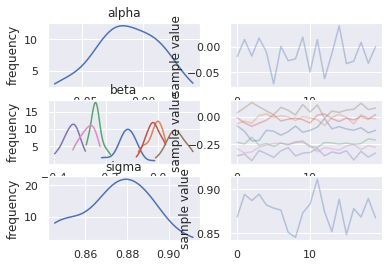

In [ ]:
pl = fit.plot()

With this model, the predictions are eventually computed, the data brought back to the original shape and the performances evaluated:

In [ ]:
samples = fit.extract(permuted=True)  # return a dictionary of arrays
y_hat = np.mean(samples["alpha"].T + np.dot(X_test, samples["beta"].T), axis=1)

In [ ]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [ ]:
# convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.513
MAE: 15.199
RMSE: 18.811
R2: 0.262


It's not possible to detect any significant improvements in the errors. The plots showing the performances are then displayed:

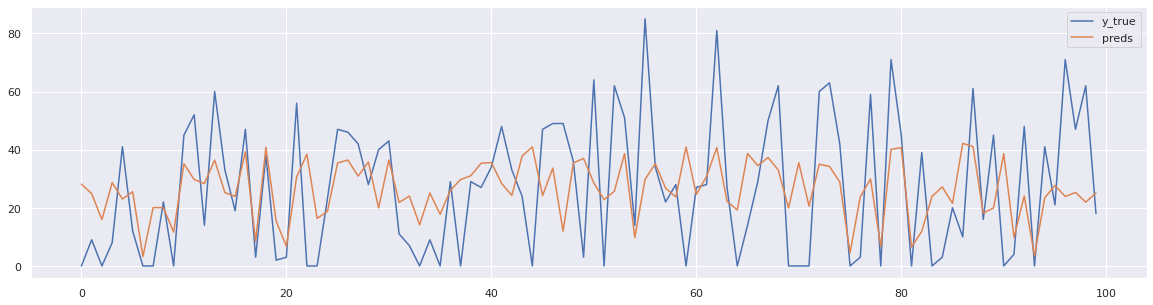

In [ ]:
fig = plt.figure(figsize=(20,5))
plt.plot(y_true[:100])
plt.plot(preds[:100])
plt.legend(["y_true", "preds"])
plt.show()

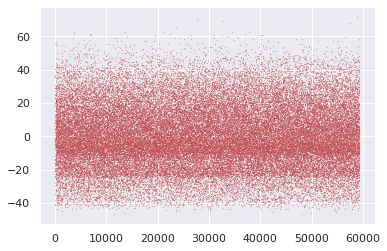

In [ ]:
err = y_true-preds
plt.scatter(np.arange(len(err)), err, s = 0.03, c="r")
plt.show()

In this case, it is possible to notice tha the scatterplot is dense above the line of -20, while it gets more sparse for values below -20. The two lines are still present, but less marked.

###### ADVI model

Now the full dataset is trained with the ADVI model, through the algorithm full rank. The distributions of the parameters are eventually displayed in plots:

In [ ]:
# prepare data for Stan model
N, D = X_train.shape
data = {'N': N, 'D': D, 'x': X_train, 'y': y_train}

In [ ]:
%%time
# create Stan model object
sm = pystan.StanModel(model_code=model_definition)
fit = sm.vb(data=data, iter=10000, algorithm="fullrank", grad_samples=10, seed=42, verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f881f0210f98ba87963f540cc707d9a5 NOW.


Wall time: 2min 15s


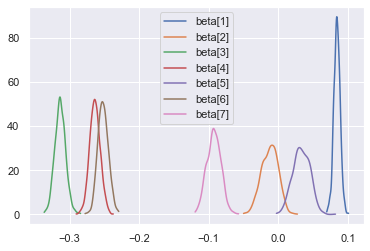

In [ ]:
pystan_utils.vb_plot_variables(fit, "beta")

In [ ]:
alpha = pystan_utils.vb_extract_variable(fit, "alpha", var_type="real")
print("alpha:", alpha)

beta = pystan_utils.vb_extract_variable(fit, "beta", var_type="vector")
print("beta:", beta)

alpha: 0.005086778648216593
beta: [ 0.08439921 -0.01136318 -0.31310841 -0.26292599  0.03284349 -0.25240585
 -0.09303844]


Again, the predictions are done and the values brought back to the original values. Eventually the performances are evaluated

In [ ]:
y_hat = alpha + np.dot(X_test, beta)

# convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))


CorrCoef: 0.515
MAE: 15.097
RMSE: 18.784
R2: 0.265


Also in this case the performances are very similar to the previous linear regresions.

In [ ]:
results_lr = pd.DataFrame()

results_lr["true"] = y_true
results_lr["predicted"] = preds
results_lr.head()

true  predicted
0   1.0  39.769745
1  39.0  23.830711
2   5.0  19.176677
3  57.0  39.812008
4   8.0  29.971876

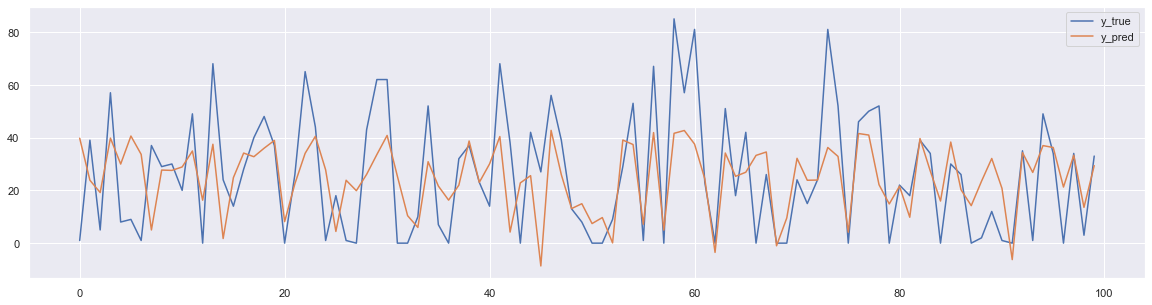

In [ ]:
fig = plt.figure(figsize=(20,5))
plt.plot(y_true[:100])
plt.plot(preds[:100])
plt.legend(["y_true", "y_pred"])
plt.show()

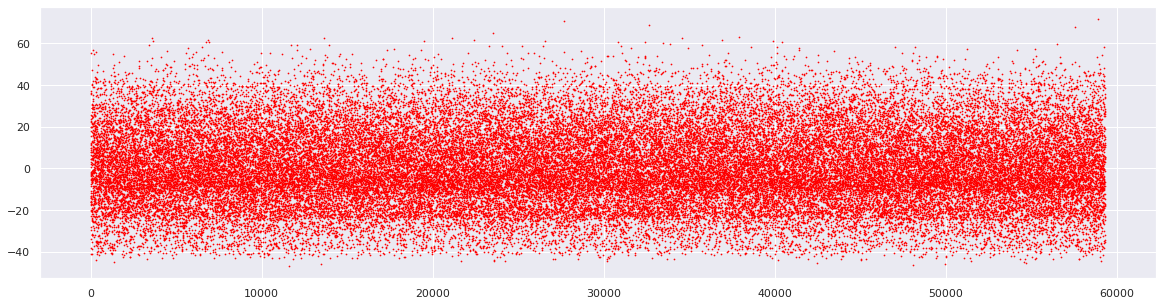

In [ ]:
err = y_true-preds
fig = plt.figure(figsize=(20,5))
plt.scatter(np.arange(len(err)), err, s=0.5, c="red")
fig.show()

# px.scatter(err)

Even though the predictions are not better than those before, now the cloud of points is much more uniform compared to the previous ones.

In [ ]:
count_10 = 0
count_20 = 0
count_5 = 0
for e in err:
#     print(e)
    if abs(e) < 5:
        count_20 += 1
    if abs(e)<10:
        count_10 += 1
    if abs(e) < 20:
        count_20 += 1

print("proportion of error less than 20: ", round(count_20/len(err), 2))
print("proportion of error less than 10: ", round(count_10/len(err), 2))
print("proportion of error less than 5: ", round(count_5/len(err), ))

proportion of error less than 20:  0.9
proportion of error less than 10:  0.41
proportion of error less than 5:  0


and the percentiles of the error distribution is computed:

90% of the errors are lower than 20 

41% of the errors are lower than 10

##### 3.1.3.4. Heteroscedastic Regression

**Generative process**

The generative process gets a bit modified to include the changing variances:

1) Draw intercept for the mean $ \alpha_\mu \sim \mathcal{N}(\alpha_\mu | 0, \gamma_\mu) $

2) Draw intercept for the standard deviation $ \alpha_\sigma \sim Cauchy(\sigma | 0, \xi) $

3) For v = 1,...,V: 

>  a) Draw coefficients for the mean $ \beta_v^\mu \sim \mathcal{N}(\beta_v^\mu | 0, \lambda_\mu) $

>  b) Draw coefficients for the standard deviation $ \beta_v^\sigma \sim \mathcal{N}(\beta_v^\sigma | 0, \lambda_\sigma) $

4) For n = 1,...,N:

> a) Draw target $Popularity_n \sim \mathcal{N}(Popularity_n | \alpha + \beta_\mu'x_n, e^{\alpha_\sigma +\beta_\sigma'x_n}) $



Eventually, heteroscedastic regression is computed, in the same way than the previous models.

In [ ]:
# define Stan model
model_definition = """
data {
    int<lower=0> N; // number of data items
    int<lower=0> D; // number of predictors
    matrix[N,D] x;  // predictor matrix
    vector[N] y;    // outcome vector
}
parameters {
    real alpha;             // intercept
    vector[D] beta;         // coefficients for predictors
    real alpha2;             // intercept
    vector[D] beta2;         // coefficients for predictors
} 
model {
    alpha ~ normal(0,10);                        // prior on the intercept
    for (d in 1:D)
        beta[d] ~ normal(0,1);             // prior on the coefficients
    alpha2 ~ normal(0,1);                        // prior on the intercept
    for (d in 1:D)
        beta2[d] ~ normal(0,1);             // prior on the coefficients
    y ~ normal(alpha + x * beta, exp(alpha2 + x * beta2));   // likelihood
}
"""

In [ ]:
# prepare data for Stan model
N, D = X_train.shape
data = {'N': N, 'D': D, 'x': X_train, 'y': y_train}

In [ ]:
%%time
# create Stan model object
sm = pystan.StanModel(model_code=model_definition)
#fit = sm.vb(data=data, iter=1000, algorithm="meanfield", grad_samples=10, seed=42, verbose=True)
fit = sm.sampling(data=data, iter=1000, chains=4, algorithm="NUTS", seed=42, verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5f217807f27b6dc6ad9d56445c85f0e4 NOW.


CPU times: user 10.8 s, sys: 1.51 s, total: 12.3 s
Wall time: 25min 6s


In [ ]:
print(fit)

Inference for Stan model: anon_model_5f217807f27b6dc6ad9d56445c85f0e4.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
alpha     5.1e-3  5.1e-5 2.5e-3  5.5e-5  3.4e-3  5.1e-3  6.8e-3    0.01   2468    1.0
beta[1]    -0.12  8.7e-5 3.3e-3   -0.12   -0.12   -0.12   -0.11   -0.11   1467    1.0
beta[2]     0.09  1.4e-4 4.2e-3    0.08    0.08    0.09    0.09    0.09    924    1.0
beta[3]     -0.2  5.3e-5 2.6e-3   -0.21   -0.21    -0.2    -0.2    -0.2   2472    1.0
beta[4]   4.7e-3  6.2e-5 2.8e-3 -9.5e-4  2.7e-3  4.7e-3  6.6e-3    0.01   2137    1.0
beta[5]    -0.31  1.3e-4 4.0e-3   -0.32   -0.31   -0.31   -0.31    -0.3    935    1.0
beta[6]     0.09  8.2e-5 3.2e-3    0.09    0.09    0.09     0.1     0.1   1499    1.0
beta[7]    -0.25  3.9e-5 1.8e-3   -0.25   -0.25   -0.25   -0.25   -0.24   2192    1.0
alpha2     -0.19  3.8e-5 2.0e-3   -0.19

In [ ]:
samples = fit.extract(permuted=True)  # return a dictionary of arrays
y_hat = np.mean(samples["alpha"].T + np.dot(X_test, samples["beta"].T), axis=1)

# convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.512
MAE: 15.071
RMSE: 18.810
R2: 0.262


##### 3.1.3.5. Neural networks

For the neural networks, a smaller dataset will be used due to the high computational cost.

In [ ]:
X_train_small = X_train[:1400,:]
y_train_small = y_train[:1400]

X_test_small = X_test[:600,:]
y_test_small = y_test[:600]

print("num small train: %d" % len(y_train_small))
print("num small test: %d" % len(y_test_small))

num small train: 1400
num small test: 600


Model definition for neural network in STAN:

In [ ]:
model_definition = """
functions {
  vector NNet(matrix X, vector bias_first, vector[] bias_hidden, real bias_output, 
                matrix w_first, matrix[] w_hidden, vector w_output, int num_hidden_layers) {
    int N = rows(X);
    int num_neurons = rows(w_first);
    matrix[N, num_neurons] layer_values[num_hidden_layers];
    vector[N] nnet_output;

    layer_values[1] = tanh(rep_matrix(bias_first',N) + X * w_first');   
    for(i in 2:(num_hidden_layers)) 
      layer_values[i] = tanh(rep_matrix(bias_hidden[i-1]',N) + layer_values[i-1] * w_hidden[i-1]');
    nnet_output = bias_output + layer_values[num_hidden_layers] * w_output;

    return nnet_output;
  }
}
data {
  int<lower=0> N;
  int<lower=0> D;
  int<lower=0> num_neurons;
  int<lower=0> num_hidden_layers;
  matrix[N,D] X;
  real y[N];
  int<lower=0> Ntest;
  matrix[Ntest,D] Xtest;
}
parameters {
  // neural network parameters
  vector[num_neurons] bias_first;
  vector[num_neurons] bias_hidden[num_hidden_layers-1];
  real bias_output;
  matrix[num_neurons, D] w_first;
  matrix[num_neurons, num_neurons] w_hidden[num_hidden_layers-1];
  vector[num_neurons] w_output;
}
model{
  vector[N] nnet_output;
  
  // priors over neural network biases
  bias_first ~ normal(0, 1);
  for (i in 1:(num_hidden_layers-1)) {
    bias_hidden[i] ~ normal(0, 1);
  }
  bias_output ~ normal(0, 1);

  // priors over neural network weights
  to_vector(w_first) ~ normal(0, 1);
  for (i in 1:(num_hidden_layers-1)) {
    to_vector(w_hidden[i]) ~ normal(0, 1);
  }
  w_output ~ normal(0, 1);
  
  // likelihood
  nnet_output = NNet(X, bias_first, bias_hidden, bias_output,
                      w_first, w_hidden, w_output, num_hidden_layers);
  y ~ normal(nnet_output, 0.1);
}
generated quantities{
  vector[Ntest] predictions;
  {
    vector[Ntest] nnet_output;
    nnet_output = NNet(Xtest, bias_first, bias_hidden, bias_output,
                      w_first, w_hidden, w_output, num_hidden_layers);
    for(i in 1:Ntest) 
      predictions[i] = nnet_output[i];
  }
}
"""

In [ ]:
# prepare data for Stan model
N, D = X_train_small.shape
num_neurons = 4
num_hidden_layers = 1
data = {'N': N, 'D': D, 'num_neurons':num_neurons, 'num_hidden_layers':num_hidden_layers, 
        'X': X_train_small, 'y': y_train_small, 'Ntest': len(X_test_small), 'Xtest': X_test_small}
print("X_train: ", X_train_small.shape, " X_test: ", X_test_small.shape)

X_train:  (1400, 7)  X_test:  (600, 7)


In [ ]:
sm = pystan.StanModel(model_code=model_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_144353aec0b83f8ae73f6f3d30020bf3 NOW.


Run inference using MCMC.

In [ ]:
# MCMC
fit = sm.sampling(data=data, iter=1000, chains=1, algorithm="NUTS", seed=42, verbose=True)

In [ ]:
preds_nnet_mcmc = np.mean(fit["predictions"], axis=0)

In [ ]:
# convert back to the original scale
preds_nnet = preds_nnet_mcmc * y_std + y_mean
y_true = y_test_small * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds_nnet)
print("num neurons: ", num_neurons, " , num layers: ", num_hidden_layers)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

num neurons:  4  , num layers:  1
CorrCoef: 0.554
MAE: 14.220
RMSE: 18.335
R2: 0.290


The next cells show a scatter plot for each feature, where it can be compared the true popularity value with the predicted ones with the neural networks.

Pedictions for feature:  danceability


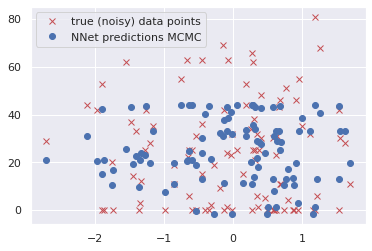

Pedictions for feature:  acousticness


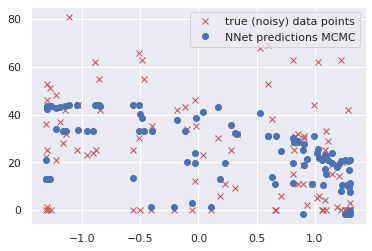

Pedictions for feature:  speechiness


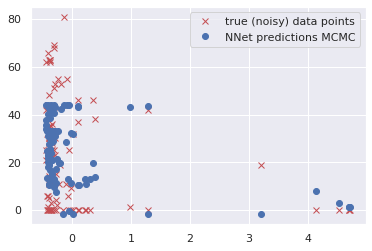

Pedictions for feature:  valence


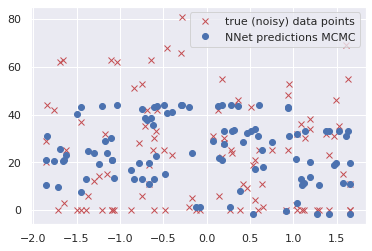

Pedictions for feature:  instrumentalness


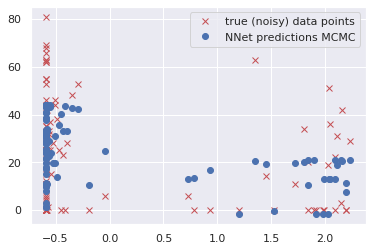

Pedictions for feature:  energy


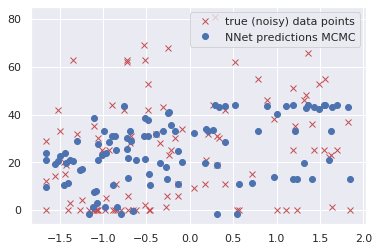

Pedictions for feature:  duration_ms


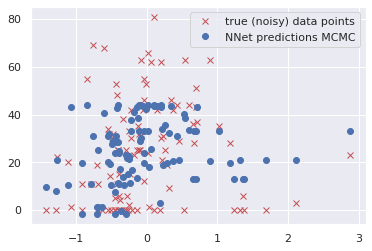

In [ ]:
for i in range(7):
  print("Pedictions for feature: ", list(x)[i])
  plt.plot(X_test_small[:100,i], y_true[:100], "rx")
  plt.plot(X_test_small[:100,i], preds_nnet[:100], 'bo')
  plt.legend(["true (noisy) data points", "NNet predictions MCMC"])
  plt.show()

As shown in previous sections, the following plot shows the predicted popularity with neural networks against the true values. As expected, the results with the neural networks are much better but they are very significant.


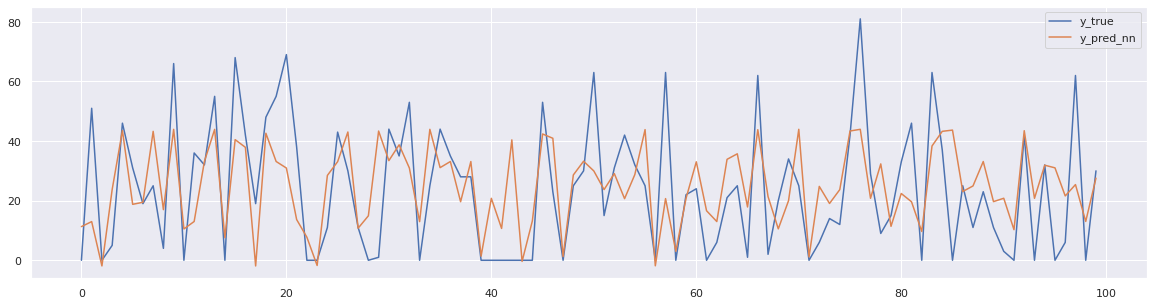

In [ ]:
fig = plt.figure(figsize=(20,5))
plt.plot(y_true[:100])
plt.plot(preds_nnet[:100])
plt.legend(["y_true", "y_pred_nn"])
plt.show()

### 3.2. Model with unobserved variables

To make things a little more difficult for the model, the values of acousticness, energy, danceability and valence will become unobserved for the modified linear regression. Based on the original PGM, this values will be predicted by the year the song was written and its tempo.

####3.2.1. Modified PGM

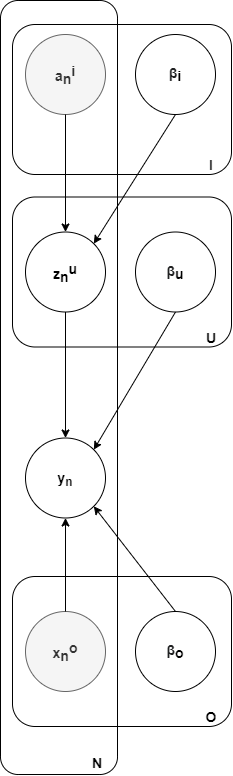

####3.2.2. Modified generative process

A linear regression will be run for this section.
The dataset consists **N** observations of the target $Popularity_n$ which depends on the **O** observed variables which include: $Speechiness_n$, $Instrumentalness_n$, $Duration_n$. All these features will be represented in $x_n$.

It also depends on the **U** unobserved variables which include: $Danceability_n$, $Valence_n$, $Energy_n$ and $Acousticness_n$ (represented by $z_n$) which are explained by the **I** remaining observed variables: $Year_n$ and $Tempo_n$ (represented by $a_n$)

The generative process will be the following:

1) Draw intercept for popularity $ \alpha_y \sim \mathcal{N}(\alpha_y | 0, \gamma_y) $

2) Draw deviation for popularity $ \sigma_y \sim Cauchy(\sigma_y | 0, \xi_y) $

3) For u = 1,...,U: 

>  a) Draw intercept for unobserved variables $ \alpha_u \sim \mathcal{N}(\alpha_u | 0, \gamma_u) $

> b) Draw deviation for unobserved variables $ \sigma_u \sim Cauchy(\sigma_u | 0, \xi_u) $

> c) For i = 1,...,I:
>> i) Draw coefficients $ \beta_i^u \sim \mathcal{N}(\beta_i^u | 0, \lambda_i) $

> d) For n = 1,...,N:
>> i) Draw target for each unobserved variable $z^u_n \sim \mathcal{N}(z^u_n | \alpha_u + \beta_u'a_n, \sigma_u^2) $

> e) Draw coefficients for the prediction of popularity $ \beta_u \sim \mathcal{N}(\beta_u | 0, \lambda_u) $

4) For o = 1,...,O: 

>  a) Draw coefficients for the prediction of popularity $ \beta_o \sim \mathcal{N}(\beta_o | 0, \lambda_o) $

5) For n = 1,...,N:

> a) Draw target $Popularity_n \sim \mathcal{N}(Popularity_n | \alpha_y + \beta_o'x_n + \beta_u'z_n, \sigma_y^2) $


#### 3.2.3. Implementation of the new model

In [ ]:
# Group each variable as described in the generative process
y = ["popularity"]
x = {'speechiness','instrumentalness','duration_ms'}
z = {'acousticness','energy','danceability','valence'}
a = {'year','tempo'}
print(y, x, z, a)
X = spot[x].values
y = spot[y].values
z = spot[z].values
A = spot[a].values

['popularity'] {'speechiness', 'instrumentalness', 'duration_ms'} {'danceability', 'acousticness', 'energy', 'valence'} {'year', 'tempo'}


In [ ]:
# standardize input 1 features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

# standardize input 2 features
A_mean = A.mean(axis=0)
A_std = A.std(axis=0)
A = (A - A_mean) / A_std

# standardize intermediate features
z_mean = z.mean(axis=0)
z_std = z.std(axis=0)
z = (z - z_mean) / z_std

# standardize popularity
y_mean = y.mean()
y_std = y.std()
y = (y - y_mean) / y_std
y = y.ravel()

##### Train on small sample of the available data

In [ ]:
train_perc = 0.66 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
A_train = A[ix_train,:]
A_test = A[ix_test,:]
z_train = z[ix_train,:]
z_test = z[ix_test,:]
y_train = y[ix_train]
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 115096
num test: 59293


Implementation of the STAN model

In [ ]:
# define Stan model
model_definition = """
data {
    int<lower=0> N; // number of data items
    int<lower=0> D; // number of predictors 1
    int<lower=0> E; // number of predictors 2
    int<lower=0> F; // number of intermediate predictors
    matrix[N,D] x;  // input 1 matrix
    matrix[N,E] a; // input 2 matrix
    matrix[N,F] z; // intermediate matrix
    vector[N] y;    // outcome vector
}
parameters {
    real alphaY;             // intercept outcome
    vector[F] alphaZ;        // intercept intermediate predictors
    vector[D] betaY1;         // coefficients for predictors 1
    vector[F] betaY2;         // coefficients for predictors 2
    matrix[E,F] betaZ;         // coefficients for intermediate predictors
    vector<lower=0>[F] sigmaZ;    // error scale for intermediate predictors
    real<lower=0> sigmaY;    // error scale for outcome
} 
model {
    alphaY ~ normal(0,10);                         // prior on the intercept
    sigmaY ~ cauchy(0,10);                        // prior on the variance Y
    

    for (f in 1:F){
        alphaZ[f] ~ normal(0,10);               // prior on the intermediate intercept
        sigmaZ[f] ~ cauchy(0,10);               // prior on the variance Z
        for (e in 1:E){
            betaZ[e,f] ~ normal(0,1);             // prior on the coefficients
            }
        z[f] ~ normal(alphaZ[f] + (a * betaZ)[f], sigmaZ[f]);   // likelihood
}

    for (d in 1:D)
        betaY1[d] ~ normal(0,1);             // prior on the coefficients
    for (f in 1:F)
        betaY2[f] ~ normal(0,1);             // prior on the coefficients

    y ~ normal(alphaY + x * betaY1 + z * betaY2, sigmaY);   // likelihood
}
"""

In [ ]:
%%time
# create Stan model object
sm = pystan.StanModel(model_code=model_definition)
fit = sm.sampling(thin=100, data=data, iter=1000, chains=4, algorithm="NUTS", seed=42, verbose=True)
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bacb32e8a65c35f220babc04520b6693 NOW.


Inference for Stan model: anon_model_bacb32e8a65c35f220babc04520b6693.
4 chains, each with iter=1000; warmup=500; thin=100; 
post-warmup draws per chain=5, total post-warmup draws=20.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alphaY      -0.03  4.6e-3   0.02  -0.08  -0.05  -0.02  -0.01 2.1e-3     25   1.22
alphaZ[1]    0.61    0.24   1.69  -5.63   0.37   1.14   1.36   2.66     51   1.12
alphaZ[2]   -0.06    0.29   1.02  -1.64  -0.71  -0.32   0.84   1.84     12   2.43
alphaZ[3]    0.54    0.15   1.07  -0.96   -0.4   0.48   0.88   3.44     48   0.93
alphaZ[4]   -0.09    0.19   1.36  -2.75   -1.1  -0.19   0.83   2.05     52   0.93
betaY1[1]   -0.24  4.4e-3   0.03  -0.29  -0.27  -0.24  -0.21  -0.18     57   0.85
betaY1[2]   -0.22  4.0e-3   0.04   -0.3  -0.25  -0.23  -0.19  -0.17     99   0.87
betaY1[3]   -0.02  9.0e-3   0.04  -0.09  -0.03  -0.02 7.5e-3   0.04     16   0.95
betaY2[1]    0.08     nan   0.04  -0.01   0.06   0.07    0.1   0.13   -210   

/usr/local/lib/python3.7/dist-packages/pystan/misc.py:366: RuntimeWarning: invalid value encountered in sqrt
  sem=msd[:, 1] / np.sqrt(ess), ess=ess, rhat=rhat,


Posterior distribution of all the latent variables in the model (alpha, betas and sigma).

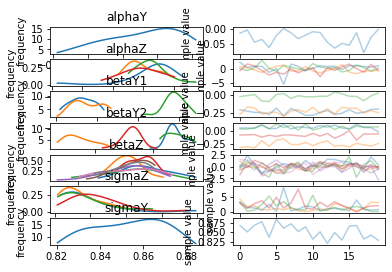

In [ ]:
pl = fit.plot()

Make predictions

In [ ]:
samples = fit.extract(permuted=True)  # return a dictionary of arrays
y_hat = np.mean(samples["alphaY"].T + np.dot(X_test, samples["betaY1"].T) + np.dot(z_test,samples["betaY2"].T), axis=1)

In [ ]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

Make predictions and test accuracy

In [ ]:
# convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.512
RAE: 0.809
RMSE: 18.787
R2: 0.260


##### Train on full dataset using ADVI

In [ ]:
# prepare data for Stan model
N, D = X_train.shape
data = {'N': N, 'D': D, 'F':F, 'E':E, 'a':A_train, 'z':z_train, 'x': X_train, 'y': y_train}

In [ ]:
%%time
# create Stan model object
sm = pystan.StanModel(model_code=model_definition)
fit = sm.vb(data=data, iter=10000, algorithm="fullrank", grad_samples=10, seed=42, verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bacb32e8a65c35f220babc04520b6693 NOW.


CPU times: user 11min 9s, sys: 18.6 s, total: 11min 28s
Wall time: 12min 35s


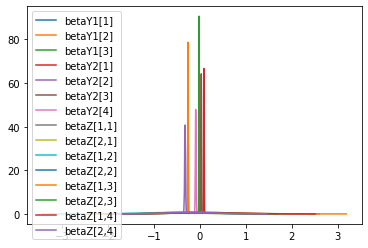

In [ ]:
pystan_utils.vb_plot_variables(fit, "beta")

In [ ]:
alpha = pystan_utils.vb_extract_variable(fit, "alphaY", var_type="real")
print("alpha:", alpha)

betaY1 = pystan_utils.vb_extract_variable(fit, "betaY1", var_type="vector")
betaY2 = pystan_utils.vb_extract_variable(fit, "betaY2", var_type="vector")
print("betaY1:", betaY1)
print("betaY2:", betaY2)

alpha: -0.0016065616929289523
betaY1: [-0.25479989 -0.2572777  -0.01463993]
betaY2: [ 0.0896433  -0.32029718  0.03233845 -0.08834793]


In [ ]:
pystan_utils.report(fit, 'alpha')
pystan_utils.report(fit, 'beta')

alphaY = -0.0016065616929289523
alphaZ[1] = 0.04973248063338167
alphaZ[2] = 0.20637463357744867
alphaZ[3] = 0.22691899563149973
alphaZ[4] = -0.6607427714860198
betaY1[1] = -0.25479988712620594
betaY1[2] = -0.25727770125047766
betaY1[3] = -0.014639932836624656
betaY2[1] = 0.089643303439254
betaY2[2] = -0.3202971823793465
betaY2[3] = 0.032338450771151765
betaY2[4] = -0.08834792770898615
betaZ[1,1] = 0.2110326194966573
betaZ[2,1] = -0.5665935795288821
betaZ[1,2] = -0.6687872781681176
betaZ[2,2] = -0.2838121395968424
betaZ[1,3] = 0.0745761647776177
betaZ[2,3] = 0.11344379015968059
betaZ[1,4] = 0.09787513326455193
betaZ[2,4] = -0.167104663043032


Make predictions and test accuracy

In [ ]:
y_hat = alpha + np.dot(X_test, betaY1) + np.dot(z_test,betaY2)

# convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nRAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, rae, rmse, r2))


### 3.3. Classification model

#### 3.3.1. PGM

The PGM for this model contains the feature vector $x_n$, the target which is the class a song is most similar to $y_n$ and the coefficient for each reference artist $\beta_c$.

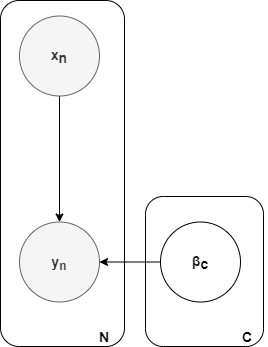

#### 3.3.2. Generative process

The generative process to categorize songs into the **C** reference artists will be the following:

1) For each reference artist c = 1,...,C: 

>  a) Draw intercept $ \alpha_c \sim \mathcal{N}(\alpha_c | 0, \gamma_c) $

> b) Draw coefficients $ \beta_c \sim \mathcal{N}(\beta_c | 0, \lambda_cI) $

2) For n = 1,...,N:
> a) Draw class $y_n \sim Categorical(y_n | Softmax(\alpha_c + \beta_c'x_n)) $

#### 3.3.3. Implementation of the categorical model

As a starting point, we have to decide what artists we want to include in our dataset to train the model based on their songs. Data is filtered according.

In [ ]:
artists = ["['Armin van Buuren']", "['Taylor Swift']", "['David Bowie']", "['Daddy Yankee']", "['Drake']", "['BTS']", "['Bob Marley & The Wailers']", "['Metallica']", "['Frank Sinatra']", "['The Beatles']"]
spot_10art = spot_class.loc[spot['artists'].isin(artists)]
spot_10art["artists"].unique()

spot_10art

acousticness  ...  year
id                     name                                                              ...      
1hHExpIRbvXfza1UyZmhIt Let's Get Lost                                           0.95800  ...  1939
1xLfz7M1dNQNXNiYIBfQhi Long Ago And Far Away                                    0.96800  ...  1939
2W889aLIKxULEefrleFBFI Someone to Watch Over Me                                 0.94700  ...  1943
6tavo8LXAi88HpuHrw4lD7 Embraceable You                                          0.91700  ...  1943
4w0gBz5PAEURZpMH0XgdVL I've Got a Crush on You                                  0.94000  ...  1943
...                                                                                 ...  ...   ...
4vTgx6h4seHvkuFh84JXYP My Time                                                  0.15100  ...  2020
2ZTKWFG6OtHI3ewy9OGNOY gold rush                                                0.81100  ...  2020
2eVabt2JFRdIS3RhEpjiFI A State Of Trance Year Mix 2020 - Intro: What I...       0.00557  ...  2020
3bkkMZEAhx7rTVz1C0itRQ Black Swan                                               0.13700  ...  2020
1gcyHQpBQ1lfXGdhZmWrHP champagne problems                                       0.92000  ...  2021

[2494 rows x 17 columns]

In [ ]:
features_to_exclude = {"mode", "key", "liveness",  "explicit", "loudness", "release_date"}
tot_features = set(spot_10art.columns)
features = tot_features - features_to_exclude

spot_10art = spot_10art[features]
spot_10art["artists"] = spot_10art["artists"].astype('category')
spot_10art["artists"] = spot_10art["artists"].cat.codes+1
spot_10art

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


duration_ms  ...  speechiness
id                     name                                                             ...             
1hHExpIRbvXfza1UyZmhIt Let's Get Lost                                           177947  ...       0.0366
1xLfz7M1dNQNXNiYIBfQhi Long Ago And Far Away                                    161613  ...       0.0330
2W889aLIKxULEefrleFBFI Someone to Watch Over Me                                 198000  ...       0.0418
6tavo8LXAi88HpuHrw4lD7 Embraceable You                                          173307  ...       0.0378
4w0gBz5PAEURZpMH0XgdVL I've Got a Crush on You                                  197240  ...       0.0476
...                                                                                ...  ...          ...
4vTgx6h4seHvkuFh84JXYP My Time                                                  234458  ...       0.0339
2ZTKWFG6OtHI3ewy9OGNOY gold rush                                                185320  ...       0.0411
2eVabt2JFRdIS3RhEpjiFI A State Of Trance Year Mix 2020 - Intro: What I...       185500  ...       0.1660
3bkkMZEAhx7rTVz1C0itRQ Black Swan                                               198261  ...       0.0851
1gcyHQpBQ1lfXGdhZmWrHP champagne problems                                       244000  ...       0.0377

[2494 rows x 11 columns]

Features of interested are selected to be part of the predictor matrix and their values are standardized.

In [ ]:
y = ["artists"]
x = features - {"popularity",'year','tempo',"artists"}
X = spot_10art[x].values
y = spot_10art[y].values
y=y.ravel()

X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

Data split into training and test set.

In [ ]:
train_perc = 0.7 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
y_train = y[ix_train]
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 1745
num test: 749


Multi class logistic regression model designed.

In [ ]:
# define Stan model
linear_regr = """

data {
    int<lower=0> N;             // number of data items
    int<lower=1> D;             // number of predictors
    int<lower=1> C;             // number of classes
    matrix[N,D] X;              // predictor matrix
    int<lower=1,upper=C> y[N];  // classes vector
}
parameters {
    vector[C] alpha;   // intercepts
    matrix[C, D] beta; // coefficients for predictors
} 
model {
    for (c in 1:C) {
        alpha[c] ~ normal(0,10); // prior on the intercepts
        beta[c] ~ normal(0,1);  // prior on the coefficients
    }
    for (n in 1:N)
        y[n] ~ categorical(softmax(alpha + beta * X[n]')); // likelihood
}
"""

In [ ]:
# prepare data for Stan model
N, D = X_train.shape
C = len(np.unique(y_train))
print("N=%d, D=%d, C=%d" % (N,D,C))
data = {'N': N, 'D': D, 'C': C, 'X': X_train, 'y': y_train}

N=1745, D=7, C=10


Compile the model and run inference using ADVI:

In [ ]:
%%time
# create Stan model object
sm = pystan.StanModel(model_code=linear_regr)
fit = sm.vb(data=data, iter=10000, algorithm="meanfield", grad_samples=10, seed=42, verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d8f1df7aac522cb7bc71d75f0c41d324 NOW.


CPU times: user 40.5 s, sys: 459 ms, total: 41 s
Wall time: 1min 45s


Plot posterior distributions for the parameters using our "pystan_utils" library:

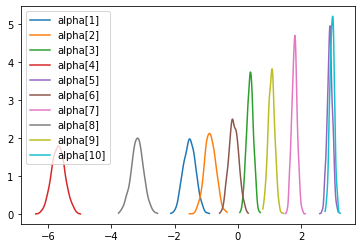

In [ ]:
# posteriors over alpha
pystan_utils.vb_plot_variables(fit, "alpha")

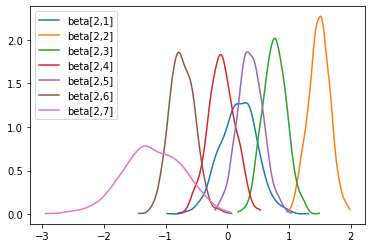

In [ ]:
# posteriors over weights for class 2
pystan_utils.vb_plot_variables(fit, "beta[2")

In [ ]:
alpha = pystan_utils.vb_extract_variable(fit, "alpha", var_type="vector")
beta = pystan_utils.vb_extract_variable(fit, "beta", var_type="matrix", dims=(C,D))

Inferreed posteriors are used to make predictions using the test set.

Based on our predictions, we compute the accuracy by the room mean squared error.

In [ ]:
# make predictions for test set
y_hat = alpha[:,np.newaxis] + np.dot(beta, X_test.T)
y_hat = np.argmax(y_hat, axis=0) + 1
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

predictions: [ 6  7  8  5  6  7  5  5  8  3  7  1  7 10  7  7  5 10  8  7  8  8  5  3
 10  5  8  7  1  7  6  7  1  4  9  9  3  5  9  7  9  7  7  3 10  3  7  7
 10  7 10  4  4 10  9  7 10  7  5 10  7 10  7  3  9  1  5  3  7 10  8  6
  4  8 10  3 10  7  3  1  7  3  1 10 10  8  1  1  7  5 10 10  1  3  5  8
  7 10  2  7  7  3  4  5  8  7  3  3  7  7  7  9 10  1  3  7  7  3  9  7
  7  8  3  8  1  9  9 10  3 10  7  3  7 10  7 10  7  7  9 10 10  5  3  7
  3  5  3  5 10  5  4  3  7  7  5  7 10  8  1  7 10  6 10  7  3 10  3 10
  7  9  5  5  7  1  1  7  7  7  7 10  7  1  8  5  7  7 10  7 10  7  3  1
  7 10  7  8 10  5  7  7  5  7  1  4  8  7  7  5  8 10  7  1  8  5  6  5
  3  1  5  7  7  5 10  7  3 10 10  8  3  5  1 10 10 10  7  5  8  2  7 10
  8  7  5  4  7  6  3  5  7  5  7  1  5  7  7  4  7  7  9 10  9  5  9 10
 10  7  3  3  9  9  5  1  6  7 10  7 10  3  7  5 10  1  1  5  9  7  1 10
  8  9  7  1 10  3  7  7  4  3  5  1  7 10  7 10  1  9  7  7 10 10  7  6
  6 10  3  7  7  5  7  4  7  7  1  5 1